# Séries temporelles - Evaluation de Julie Lallement

## Exercice 1

Cette partie consiste à modéliser la production mensuelle de bière en Australie entre janvier 1956 et dévrier 1991, puis de la prédire sur 12 mois.

### Importation des bibliothèques et fonctions

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import plotly.offline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as stattools
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import math
from statsmodels.tsa.arima.model import ARIMA
import datetime

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Importation des données

In [ ]:
df = pd.read_csv("/content/beer.txt", header = None)
df.head()

,0
0,93.2
1,96.0
2,95.2
3,77.1
4,70.9


On voit qu'il n'y a pas de données sur la temporalité de la production, nous allons donc l'ajouter.

In [ ]:
# Ajout de la colonne de date en utilisant un offset de temps 'MS' pour mois début
df['date'] = pd.date_range(start='01-1956', periods=len(df), freq='MS')

# Définir la colonne 'date' comme index
df.set_index('date', inplace=True)

df.tail()

,0
date,
1990-10-01,193.8
1990-11-01,208.4
1990-12-01,197.0
1991-01-01,164.0
1991-02-01,148.0


In [ ]:
df = df.reset_index()

In [ ]:
df.head()

,date,0
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9


In [ ]:
#Insérer les olonnes année et mois afin de pouvoir observer s'il existe des sous-saisonnalité plus tard
df['date']= pd.DatetimeIndex(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [ ]:
print(df)

          date      0  year  month
0   1956-01-01   93.2  1956      1
1   1956-02-01   96.0  1956      2
2   1956-03-01   95.2  1956      3
3   1956-04-01   77.1  1956      4
4   1956-05-01   70.9  1956      5
..         ...    ...   ...    ...
417 1990-10-01  193.8  1990     10
418 1990-11-01  208.4  1990     11
419 1990-12-01  197.0  1990     12
420 1991-01-01  164.0  1991      1
421 1991-02-01  148.0  1991      2

[422 rows x 4 columns]


In [ ]:
df.describe()

,0,year,month
count,422.000000,422.000000,422.000000
mean,134.768720,1973.085308,6.476303
std,34.798046,10.163150,3.465220
min,64.800000,1956.000000,1.000000
25%,105.200000,1964.000000,3.000000
50%,137.350000,1973.000000,6.000000
75%,159.075000,1982.000000,9.000000
max,217.800000,1991.000000,12.000000


Il y a 422 données dans le dataset "beer.txt" pour une seule variable, correspondant à la production de bière en Australie pendant les 35 années, nous ne connaissons pas l'unité. On peut voir que la moyenne est à 134.8 et la médiane à 137, il y aura donc peut-être un outlier vers une grosse production.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    422 non-null    datetime64[ns]
 1   0       422 non-null    float64       
 2   year    422 non-null    int64         
 3   month   422 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 KB


Il n'y a pas de valeurs manquantes, nous pouvons donc analyser ce dataset.

### Analyses

In [ ]:
#Définir les variables
df.columns = ['date', 'ProdBeer', 'year', 'month']
data = df['ProdBeer']
year = df['year']
month = df['month']
date = df['date']
df.head()

,date,ProdBeer,year,month
0,1956-01-01,93.2,1956,1
1,1956-02-01,96.0,1956,2
2,1956-03-01,95.2,1956,3
3,1956-04-01,77.1,1956,4
4,1956-05-01,70.9,1956,5


#### Test statistique de stationnarité

La stationnarité est un concept pour les séries temporelles où les paramètres statistiques comme la moyenne, la variance, etc. sont tous constants dans le temps.

Il existe plusieurs façons de détecter la saisonnalité dans une série temporelle en utilisant Python. L'une des méthodes les plus courantes consiste à utiliser des méthodes statistiques, comme le test de Dickey-Fuller ou le test de KPSS, pour vérifier si la série temporelle est stationnaire ou non. Si la série temporelle n'est pas stationnaire, il est probable qu'elle ait une saisonnalité.

Un exemple de test de Dickey-Fuller pour vérifier la stationnarité d'une série temporelle serait de tester l'hypothèse nulle H0: il existe une racine unitaire (c'est-à-dire que la série temporelle n'est pas stationnaire) contre l'hypothèse alternative H1: il n'y a pas de racine unitaire (c'est-à-dire que la série temporelle est stationnaire). On peut utiliser la statistique de test de Dickey-Fuller augmentée (ADF) pour effectuer ce test. Si la p-valeur associée à la statistique de test est inférieure à un seuil de signification prédéfini (généralement 0,05), on rejette l'hypothèse nulle et on conclut que la série temporelle est stationnaire. Sinon, on ne peut pas rejeter l'hypothèse nulle et on ne peut pas conclure que la série temporelle est stationnaire.

In [ ]:
# Test de Dickey-Fuller
result = stattools.adfuller(df["ProdBeer"])

# Résultats du test
print('Statistique de test : ', result[0])
print('p-valeur : ', result[1])
print('Nombre de lags : ', result[2])
print('Nombre de observations utilisées : ', result[3])
print('Critères d’arrêt : ', result[4])

# Interprétation des résultats
alpha = 0.05
if result[1] < alpha:
    print("On rejette l'hypothèse nulle, la série temporelle est stationnaire")
else:
    print("On ne peut pas rejeter l'hypothèse nulle, la série temporelle n'est pas stationnaire")

Statistique de test :  -1.8123779109436913
p-valeur :  0.37433395099622924
Nombre de lags :  17
Nombre de observations utilisées :  404
Critères d’arrêt :  {'1%': -3.44664043608676, '5%': -2.868720756230461, '10%': -2.5705951311145965}
On ne peut pas rejeter l'hypothèse nulle, la série temporelle n'est pas stationnaire


Ici, l'hypothèse nulle n'est pas rejetée, on ne peut pas conclure que la série temporelle est stationnaire au moins du point de vue de la racine unitaire (test d'ADF), nous allons donc pousser l'analyse.

#### Analyse de la stationnarité

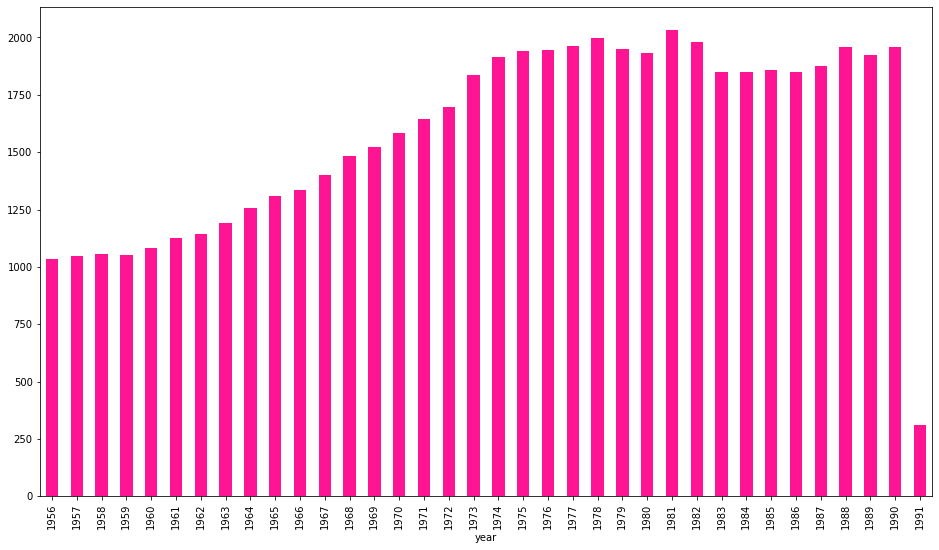

In [ ]:
df.groupby(['year']).sum()['ProdBeer'].plot(figsize=(16,9), kind='bar', color = 'deeppink');

On peut voir que la production de bière augmentait de 1956 à environ 1976, pour ensuite être constante jusqu'en 1991, où elle chute mais cela est dû au fait que nous n'avons pas l'année entière de 1991. On voit donc une première partie d'augmentation de la production sur les années, puis une évolution constante, il y a donc une première tendance.

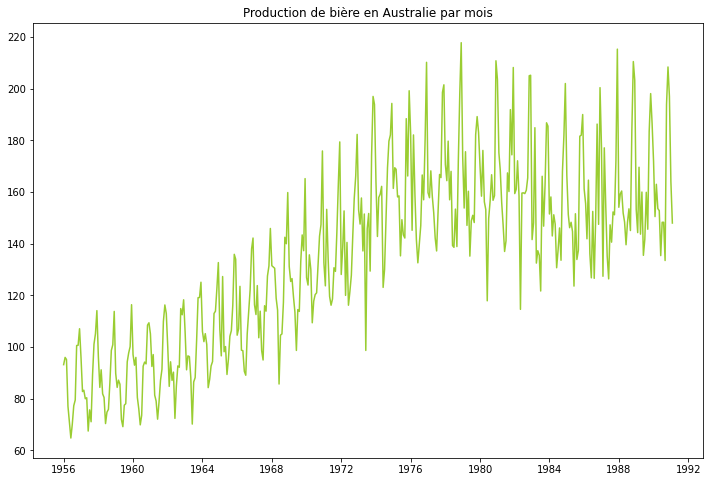

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df['date'], data, color='yellowgreen')
plt.title('Production de bière en Australie par mois')
plt.show()

On observe cette même tendance sur ce graphique, avec des courbes pouvant ressembler à de la saisonnalité, nous allons donc "zoomer" sur la temporalité.

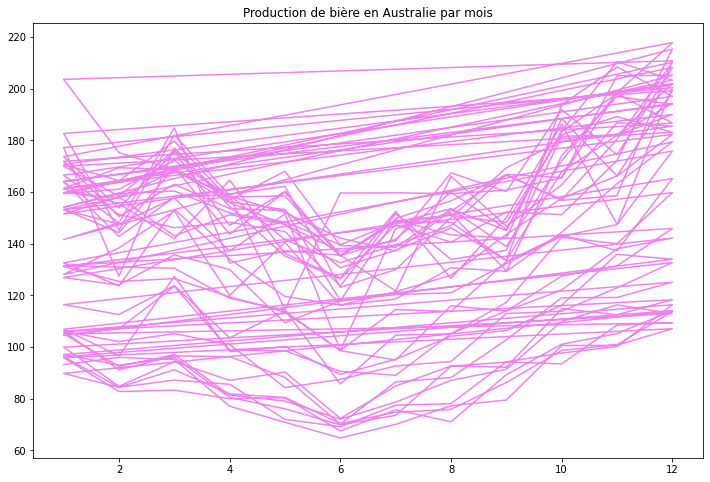

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(month, data, color='violet')
plt.title('Production de bière en Australie par mois')
plt.show()

On observe sur ce graphique qu'au moins numéro 6 (juin), la production de bière baisse quasiment toujours. On soupçonne donc un schéma qui se répète. Il y aurait moins de production en hiver, pour cela nous allons visualiser cette production par saison.

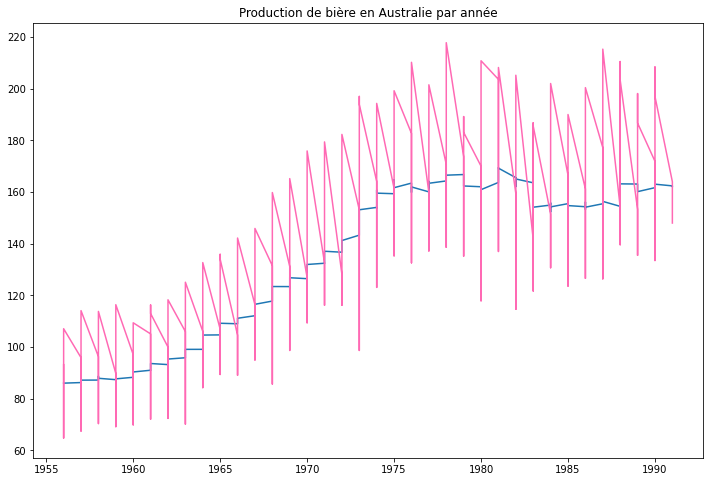

In [ ]:
plt.figure(figsize=(12,8))
# Ajouter une moyenne mobile pour visualiser la tendance
rolling_mean = df['ProdBeer'].rolling(window=12).mean()
plt.plot(year, rolling_mean)
plt.plot(year, data, color='hotpink')
plt.title('Production de bière en Australie par année')
plt.show()

Ici, on peut voir que la tendance positive est graduelle.

In [ ]:
#Définir les saisons ATTENTION ICI NOUS SOMMES EN AUSTRALIE
autumn = [3, 4, 5]
winter = [6, 7, 8]
spring = [9, 10, 11]
summer = [12, 1, 2]

# Ajouter une colonne pour la saison
df['season'] = None
df.loc[df['month'].isin(autumn),'season'] = 'Autumn'
df.loc[df['month'].isin(winter),'season'] = 'Winter'
df.loc[df['month'].isin(spring),'season'] = 'Spring'
df.loc[df['month'].isin(summer),'season'] = 'Summer'

df.head()

,date,ProdBeer,year,month,season
0,1956-01-01,93.2,1956,1,Summer
1,1956-02-01,96.0,1956,2,Summer
2,1956-03-01,95.2,1956,3,Autumn
3,1956-04-01,77.1,1956,4,Autumn
4,1956-05-01,70.9,1956,5,Autumn


Text(0.5, 1.0, 'Production de bière en fonction des saisons')

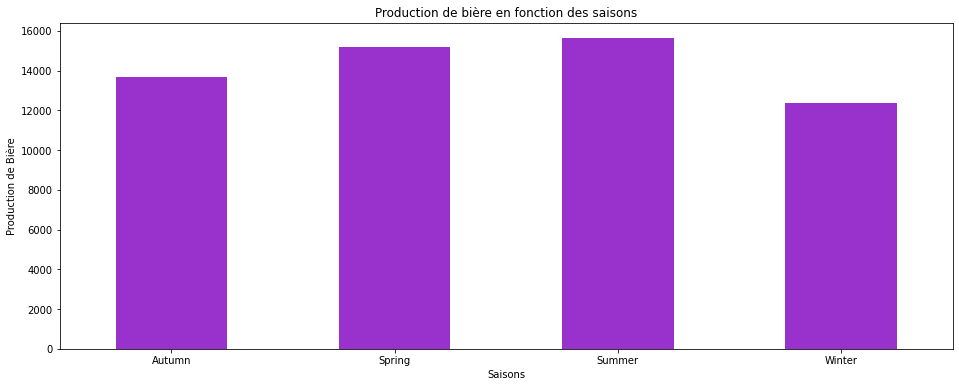

In [ ]:
df.groupby(['season']).sum()['ProdBeer'].plot(figsize=(16,6), kind='bar', color = 'darkorchid', rot=0)
plt.xlabel("Saisons")
plt.ylabel("Production de Bière")
plt.title("Production de bière en fonction des saisons")

On confirme notre hypothèse de départ indiquant qu'il y a une baisse de production de bière en hiver en Australie, ainsi qu'une augmentation en été. Il y a donc une saisonnalité et une tendance. Nous allons effectuer des tests statistiques afin de confirmer cela.


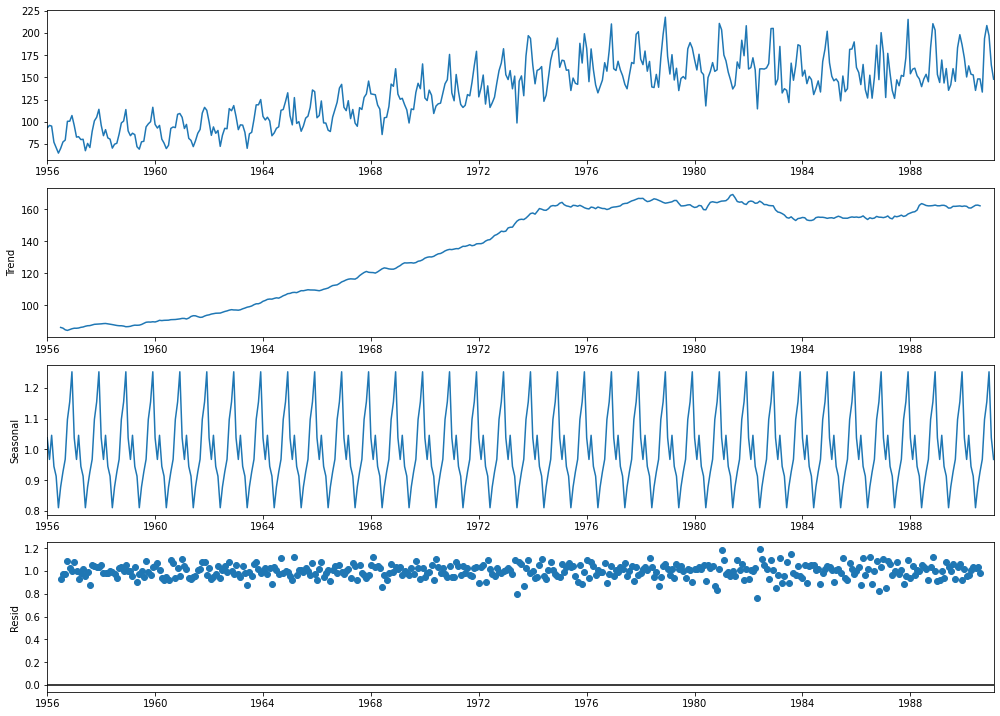

In [ ]:
# Décomposer la série temporelle en ses composantes tendance, saisonnière et
#aléatoire, puis afficher les composantes saisonnières

seasonal = df.copy().set_index('date').sort_index()


analysis = seasonal[['ProdBeer']].copy()
analysis.sort_index(inplace=True)
decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = decompose_result_mult.plot();
fig.set_size_inches((14, 10))
fig.tight_layout()
plt.show()

Ici, nous avons décomposé automatiquement la série temporelle afin d'avoir une vue plus claire des composants.
On voit clairement une tendance vers le haut de 1956 à 1970 environ, nous tronquerons donc notre dataset à partir de 1970 pour effectuer notre modèle.
Nous voyons également un pattern de saisonnalité d'une durée d'un an, ainsi qu'une sous-saisonnalité.
Il est plus facile d'analyser la série si nous supprimons la saisonnalité de nos données, ce que nous allons faire.

### Stationnarisation

Pour rappel, le but de ce notebook est de prédire la production de bière dans les 12 mois. Comme cette production a une tendance avant 1970, nous la tronquerons à partir de cette date.

In [ ]:
df_filtre= df[df['date'] > pd.to_datetime('1970-01-01')]

Nous allons maintenant regarder la saisonnalité de ce dataset tronqué.

Les tests de stationnarité permettent de vérifier si une série est stationnaire ou non. Il y a deux types de test différents : les tests de stationnarité, comme le test KPSS, pour lesquels l'hypothèse nulle H0 est que la série est stationnaire , et les tests de racine unitaire comme le test de Dickey-Fuller, le test augmenté de Dickey-Fuller (ADF), ou encore le test de Phillips-Perron (PP) pour lesquels l'hypothèse nulle est que la série a été générée par un processus présentant une racine unitaire, et donc, qu'elle n'est pas stationnaire.

In [ ]:
# Test de Dickey-Fuller
result = stattools.adfuller(df_filtre["ProdBeer"])

# Résultats du test
print('Statistique de test : ', result[0])
print('p-valeur : ', result[1])
print('Nombre de lags : ', result[2])
print('Nombre de observations utilisées : ', result[3])
print('Critères d’arrêt : ', result[4])

# Interprétation des résultats
alpha = 0.05
if result[1] < alpha:
    print("On rejette l'hypothèse nulle, la série temporelle est stationnaire")
else:
    print("On ne peut pas rejeter l'hypothèse nulle, la série temporelle n'est pas stationnaire")

Statistique de test :  -2.948857567540065
p-valeur :  0.039954402535327824
Nombre de lags :  15
Nombre de observations utilisées :  237
Critères d’arrêt :  {'1%': -3.4582467982399105, '5%': -2.8738137461081323, '10%': -2.5733111490323846}
On rejette l'hypothèse nulle, la série temporelle est stationnaire


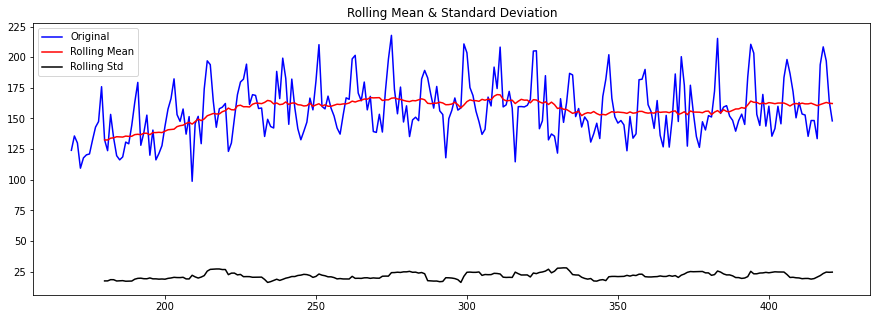

Results of Dickey-Fuller Test:
Test Statistic                  -2.948858
p-value                          0.039954
#Lags Used                      15.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [ ]:
test_stationarity(df_filtre['ProdBeer'])

D'après les résultats du test de Dickey Fuller
Statistique du test : (-2.94) < Valeur critique (5%) : (-2.87).
Valeur p (0,05) < 0,05

Ici, le test d'ADF rejette l'hypothèse nulle que la série présente une racine unitaire et retient l'hypothèse alternative qu'elle est stationnaire. Mais seulement dans le sens de la racine unitaire.

Nous vérifierons la stationnarité avec un ACF, puisque c'est la méthode la plus efficace et que nous avons repéré une saisonnalité à l'oeil.

In [ ]:
df_filtre.head()

,date,ProdBeer,year,month,season
169,1970-02-01,124.0,1970,2,Summer
170,1970-03-01,135.7,1970,3,Autumn
171,1970-04-01,130.0,1970,4,Autumn
172,1970-05-01,109.4,1970,5,Autumn
173,1970-06-01,117.8,1970,6,Winter


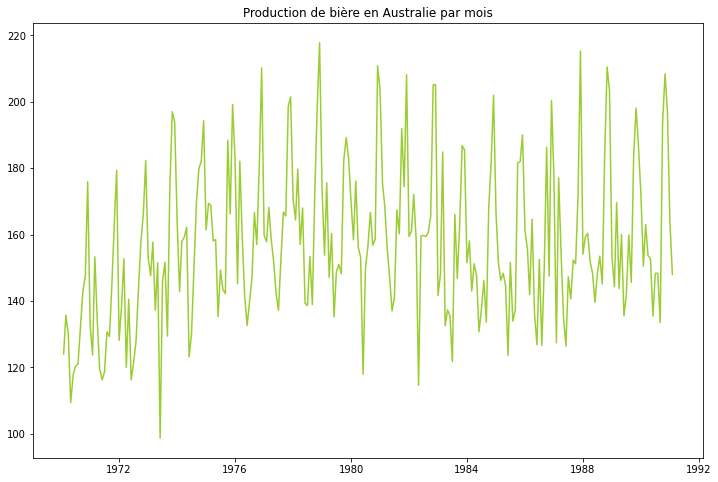

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df_filtre['date'], df_filtre["ProdBeer"], color='yellowgreen')
plt.title('Production de bière en Australie par mois')
plt.show()

In [ ]:
df_copy_acf = df_filtre.copy()
df_copy_acf  = df_copy_acf[['date', 'ProdBeer']]
df_copy_acf = df_copy_acf.set_index('date')
df_copy_acf

,ProdBeer
date,
1970-02-01,124.0
1970-03-01,135.7
1970-04-01,130.0
1970-05-01,109.4
1970-06-01,117.8
...,...
1990-10-01,193.8
1990-11-01,208.4
1990-12-01,197.0


In [ ]:
N = len(df_copy_acf)
m = 1
nlag_max = round(10*math.log10(N/m), 0)
nlag_max

24.0

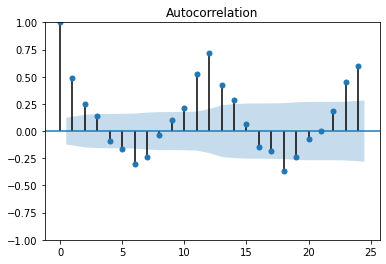

In [ ]:
plot_acf(df_copy_acf['ProdBeer'], ax=None, lags=nlag_max, alpha=0.05)
plt.show()

On voit qu'avec une ACF, notre série présente une saisonnalité car des comportements similaires sont observés de manière périodique.

On effectue une différenciation en « saisonnalité » si des
comportements similaires sont observés de manière
périodique. Par exemple, si ACF (12), ACF (24), . . .
sont proches de 1, on utilise une différenciation en
« saisonnalité » avec s = 12.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



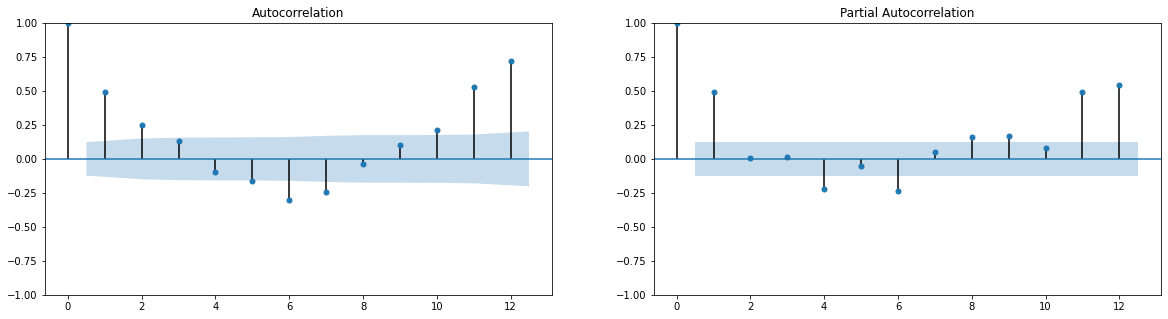

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(df_copy_acf['ProdBeer'], ax=ax[0], lags = 12)
plot_pacf(df_copy_acf['ProdBeer'], ax=ax[1], lags = 12)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



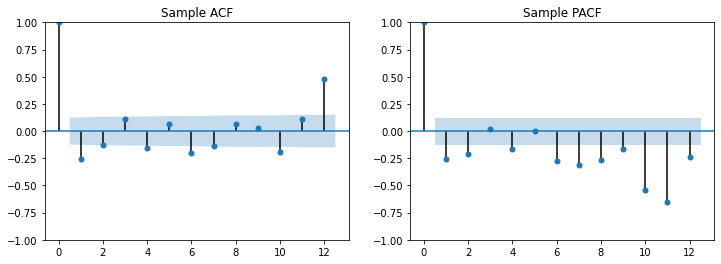

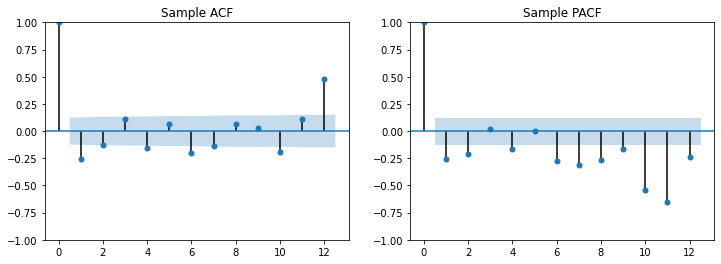

In [ ]:
def plot_acf_pacf(series, nlags):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sm.graphics.tsa.plot_acf(series, lags=nlags, ax = axes[0])
    axes[0].set_title('Sample ACF')

    sm.graphics.tsa.plot_pacf(series, lags=nlags, ax = axes[1])
    axes[1].set_title('Sample PACF')

    return fig

plot_acf_pacf(df_copy_acf.diff().dropna(), 12)

Avec une différenciation avec un lag de 12, la série devient stationnaire.

### Modèle SARIMA

Le modèle SARIMA est une extension du modèle ARIMA qui peut traiter les effets saisonniers des données.
Il a une sorte de 2 ordres (p,d,q) x (P,D,Q,M).
(p,d,q) est l'ordre qui est similaire à l'ordre du modèle ARIMA.
(P,D,Q,M) est connu comme l'ordre saisonnier où (P,D,Q) sont similaires aux (p,d,q) du modèle ARIMA. Nous effectuerons notre modèle avec une méthode empirique, que nous confirmerons avec un algorithme de recherche.

Nous allons tout d'abord diviser notre dataset en 2 parties : une partie train pour entraîner notre modèle, et une partie test pour le tester. Le 4 dernières années seront gardées en "test"

In [ ]:
split_date  = datetime.datetime.strptime('1988-01-01', '%Y-%m-%d')
df_train = df_copy_acf.loc[df_copy_acf.index < split_date]
df_test = df_copy_acf.loc[df_copy_acf.index >= split_date]

In [ ]:
stepwise_model = auto_arima(df_train,
                            start_p=0,
                            start_q=0,
                            max_p=5,
                            max_d=5,
                            max_q=5,
                            start_P=1,
                            start_Q=1,
                            max_P=2,
                            max_D=2,
                            max_Q=2,
                            max_order=10,
                            m=12,
                            seasonal=True,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1950.998, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1861.839, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1848.778, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1949.072, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1928.151, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1813.762, Time=1.21 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1726.845, Time=2.56 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=4.63 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.15 sec
 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=3.07 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2

Meilleur modèle:  ARIMA(0,1,1)(1,0,2)


In [ ]:
print(stepwise_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  215
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -857.423
Date:                                 Wed, 25 Jan 2023   AIC                           1726.845
Time:                                         20:52:21   BIC                           1747.041
Sample:                                     02-01-1970   HQIC                          1735.006
                                          - 12-01-1987                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.006      0.302      0.763      -0.010       0

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



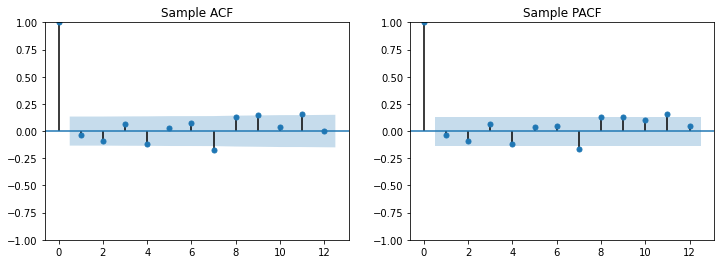

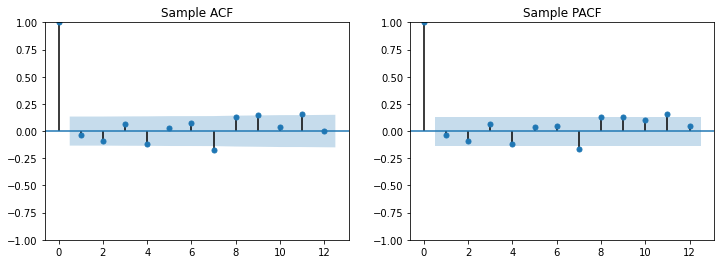

In [ ]:
plot_acf_pacf(stepwise_model.resid(), 12)

In [ ]:
#Ici, j'utilise une autre méthode pour vérifier que je ne me suis pas trompée

model = sm.tsa.statespace.SARIMAX(df_train, trend='n', order=(0,1,1), seasonal_order=(1,0,2,12))
results = model.fit()
results.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                ProdBeer   No. Observations:                  215
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -855.496
Date:                                 Wed, 25 Jan 2023   AIC                           1720.992
Time:                                         21:06:53   BIC                           1737.822
Sample:                                     02-01-1970   HQIC                          1727.793
                                          - 12-01-1987                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9036      0.032    -27.824      0.000      -0.967      -0.840
ar.S.L12       0.9989      0.005    184.218      0.000       0.988       1.010
ma.S.L12      -0.8029      0.125     -6.417      0.000      -1.048      -0.558
ma.S.L24      -0.1282      0.084     -1.521      0.128      -0.293       0.037
sigma2       149.1048     19.028      7.836      0.000     111.810     186.399
===================================================================================
Ljung-Box (L1) (Q):                   4.21   Jarque-Bera (JB):                 4.61
Prob(Q):                              0.04   Prob(JB):                         0.10
Heteroskedasticity (H):               1.67   Skew:                            -0.28
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Analyse des résidus

Le test de Ljung-Box est utilisé pour vérifier si les résidus d'un modèle statistique sont indépendants et ont une variance constante, ce qui est caractéristique d'un bruit blanc. Le test consiste à calculer la somme des carrés des résidus corrigés de moyenne pour des sous-séries de longueur croissante, et de les comparer à ce qui serait attendu si les résidus étaient réellement un bruit blanc. Si les résidus sont indépendants et ont une variance constante, ces sommes devraient être proches de ce qui est attendu pour un bruit blanc.

 En général, on considère qu'un résultat inférieur à 0.05 indique que les résidus ne sont pas un bruit blanc et donc que le modèle n'est pas adapté.
 Ici on a 3.51 > 0.05, le résidu est donc un bruit blanc.

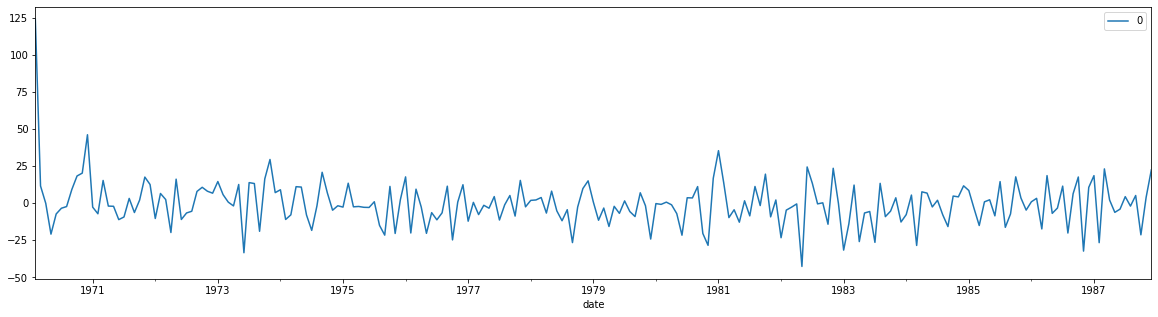

In [ ]:
residuals = pd.DataFrame(stepwise_model.resid())
residuals.plot(figsize=(20,5))
plt.show()

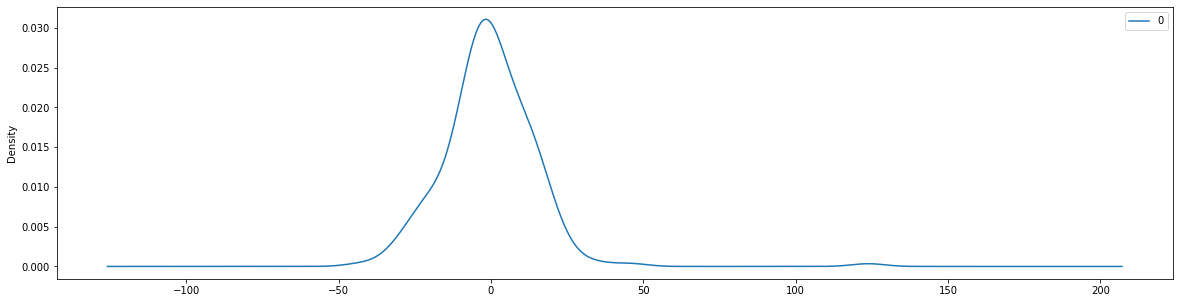

                0
count  215.000000
mean    -0.349511
std     15.741884
min    -42.613072
25%     -7.832074
50%     -1.416390
75%      7.985230
max    123.826853


In [ ]:
residuals.plot(kind='kde', figsize=(20,5))
plt.show()
print(residuals.describe())

D'après les graphiques des résidus, nous pouvons observer que le processus a une moyenne constante, centrée autour de zéro et une variance constante. De plus, graphiquement, il semble correspondre à une distribution normale.



Nous allons maintenant analyser de manière plus globale nos résultats :

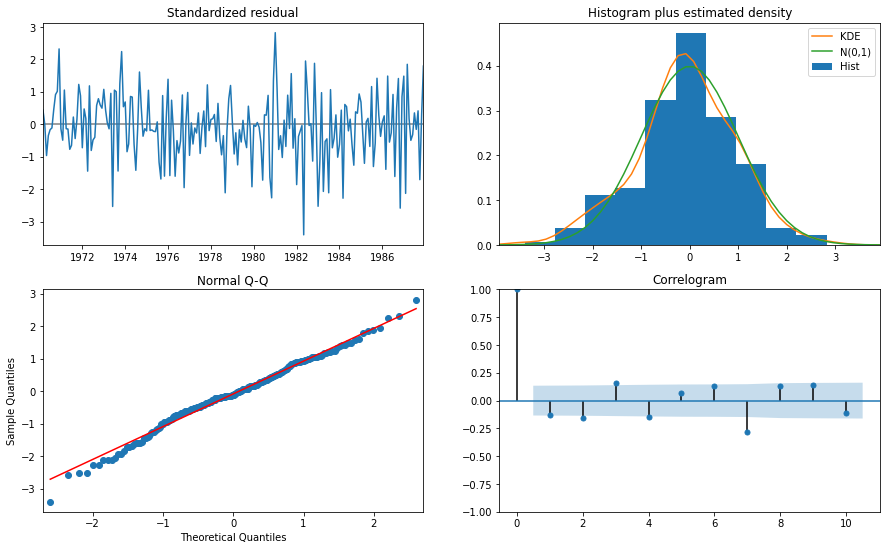

In [ ]:
stepwise_model.plot_diagnostics(figsize=(15,9));

- L'histogramme de densité montre une distribution normale avec une moyenne proche de 0, comme indiqué précedemment,

- le graphique des résidus fluctuent également autour de 0

- dans le graphique "theoretical quantiles", nos points sont alignés avec la ligne rouge, indiiquant que la distribution n'est pas biaisée,

-  le corrélogramme des résidus indique qu'ils ne sont pas autocorrélés. Toutes les autocorrélations sont donc indiquées dans le modèle.

Le modèle semble être adapté, nous pouvons effectuer notre prédiction.

### Prévisions

In [ ]:
predictions = stepwise_model.predict(n_periods = 38, X=df_test)

In [ ]:
predictions

1988-01-01    165.018032
1988-02-01    146.876887
1988-03-01    163.873857
1988-04-01    151.761738
1988-05-01    140.908268
1988-06-01    130.738939
1988-07-01    144.222503
1988-08-01    144.844964
1988-09-01    149.022330
1988-10-01    165.563637
1988-11-01    174.212917
1988-12-01    199.371543
1989-01-01    163.512977
1989-02-01    149.762872
1989-03-01    162.012519
1989-04-01    151.858629
1989-05-01    141.903121
1989-06-01    131.684452
1989-07-01    144.252134
1989-08-01    145.445521
1989-09-01    148.908899
1989-10-01    167.792559
1989-11-01    174.104008
1989-12-01    197.177897
1990-01-01    163.670021
1990-02-01    150.065208
1990-03-01    162.188834
1990-04-01    152.142708
1990-05-01    142.292894
1990-06-01    132.182666
1990-07-01    144.621008
1990-08-01    145.803750
1990-09-01    149.232793
1990-10-01    167.921206
1990-11-01    174.168600
1990-12-01    197.003517
1991-01-01    163.847107
1991-02-01    150.386070
Freq: MS, dtype: float64

In [ ]:
predictions_df = predictions.to_frame()

In [ ]:
predictions_df.columns = ['pred']

In [ ]:
predictions_df.tail()

,pred
1990-10-01,167.921206
1990-11-01,174.168600
1990-12-01,197.003517
1991-01-01,163.847107
1991-02-01,150.386070


In [ ]:
sarima_pred = stepwise_model.predict(n_periods = 38, X=df_test) # Il y a 38 mois à prédire

df_test["sarima_pred"] = sarima_pred
df_test

<ipython-input-92-78b1478d4fa0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ProdBeer,sarima_pred
date,,
1988-01-01,154.1,165.018032
1988-02-01,159.3,146.876887
1988-03-01,160.4,163.873857
1988-04-01,151.9,151.761738
1988-05-01,148.4,140.908268
1988-06-01,139.6,130.738939
1988-07-01,148.2,144.222503
1988-08-01,153.5,144.844964
1988-09-01,145.1,149.022330


### Evaluation

Une analyse à posteriori permet de quantifier la différence entre les prévision et les réalisations. Nous utiliserons pour se faire le RMSE.

In [ ]:
mse = mean_squared_error(df_test['ProdBeer'], predictions_df['pred'])
mse

164.45713335696706

In [ ]:
from math import sqrt

rmse = sqrt(mse)
rmse

12.82408411376684

In [ ]:
df_test.describe()

,ProdBeer,sarima_pred
count,38.000000,38.000000
mean,161.797368,156.588357
std,21.655790,16.879785
min,133.500000,130.738939
25%,148.050000,144.995103
50%,153.550000,151.073904
75%,171.325000,164.731989
max,210.500000,199.371543


Le RMSE (Root Mean Squared Error) est une métrique couramment utilisée pour évaluer la qualité des prévisions en séries temporelles. Il mesure la moyenne des erreurs au carré entre les valeurs prévues et les valeurs réelles, et est exprimé dans les mêmes unités que les données d'entrée.

Ici, nous avons un RMSE de 12.8, ce qui est en général considéré comme un bon résultat au vu de notre moyenne et écart-type. Cependant cela pourrait être amélioré.

In [ ]:
# Sélectionnez les 12 dernières prévisions de votre modèle
predictions_12 = predictions[-12:]

# Sélectionnez les 12 dernières valeurs réelles de votre série temporelle
y_test_12 = df_test['ProdBeer'][-12:]

# Calculez le MSE
mse12 = mean_squared_error(y_test_12, predictions_12)

In [ ]:
mse12

186.5030555360605

In [ ]:
rmse12 = sqrt(mse12)
rmse12

13.656612154412986

Le RMSE augmente lorsque l'on évalue la qualité prédictive de notre modèle sur les 12 derniers mois seulement. Il faudrait probablement revoir les paramètres de notre modèle, peut-être avec de la cross-validation, d'autres paramètres pour le modèle ou sinon un modèle plus efficace.

# Exercice 2


Cette partie consiste à prédire la concentration d'ozone à horizon d'un jour sur la ville de Rennes, avec un dataset du 01/04/1995 au 30/09/2002.

 Il y a 24 variables  :


* (sans nom) : date (au format aaaammjj)
* maxO3 : teneur maximale en ozone observée sur la journée (en µ gr.m−3)
* T6, T9, T12, T15, T18 : température observée à 9h, 12h et 15h (en ◦C)
* Ne6, Ne9, Ne12, Ne15, Ne18 : nébulosité observée à 6h, 9h, 12h, 15h et 18h (en octas)
* Vdir6, Vdir9, Vdir12, Vdir15, Vdir18 : direction du vent observée à 6h, 9h, 12h,15h et 18h
* Vvit6, Vvit9, Vvit12, Vvit15, Vvit18 : vitesse du vent observée à 6h, 9h, 12h, 15h et 18h (en m.s−1)
* Vx : composante est-ouest du vent observée (en m.s−1)
* maxO3v : teneur maximale en ozone observée la veille (en µ gr.m−3)

## Importations des bibliothèques

In [ ]:
!pip install pystan~=2.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys

In [ ]:
sys.version

'3.8.10 (default, Nov 14 2022, 12:59:47) \n[GCC 9.4.0]'

In [ ]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.express as px
from datetime import datetime, timedelta
from datetime import datetime
from sklearn.impute import KNNImputer
import calendar
from prophet import Prophet
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import plotly.offline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as stattools
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import math
from statsmodels.tsa.arima.model import ARIMA
import datetime
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

## Importation du fichier

In [ ]:
df2 = pd.read_csv('/content/ozone_complet.txt', sep=';')
df2.head()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8


Nous allons indiquer que l'index est la donnée temporelle.

In [ ]:
df2.index = pd.to_datetime(df2.index, format='%Y%m%d')
df2.tail()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
2002-09-26,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
2002-09-27,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
2002-09-28,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0
2002-09-29,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0
2002-09-30,99.0,9.4,13.8,21.7,24.7,19.8,6.0,6.0,6.0,3.0,...,140.0,2.0,140.0,2.0,120.0,4.0,110.0,3.0,1.2856,89.0


Le dataset s'arrête bien à la date indiquée, nous avons effectué la bonne transformation.

In [ ]:
df2.describe()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
count,1391.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1462.000000,1462.000000,1462.000000,1462.000000,...,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1391.000000
mean,85.070453,12.255913,16.349146,19.397334,20.327136,18.752905,5.010260,5.140903,5.321477,5.120383,...,195.119617,3.756664,204.326726,4.531100,206.951470,4.812714,190.143541,4.401914,-0.708441,85.074623
std,23.316925,3.900193,4.112326,4.907907,5.267362,5.074725,2.913168,2.577873,2.334590,2.341895,...,107.235355,1.893428,105.838169,2.066662,110.776403,2.070687,121.167570,1.761356,3.451230,23.318205
min,33.200000,-1.600000,4.500000,3.900000,5.700000,4.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.392300,33.200000
25%,68.000000,9.900000,13.800000,16.150000,16.750000,15.500000,2.000000,3.000000,4.000000,3.000000,...,100.000000,2.000000,110.000000,3.000000,100.000000,3.000000,60.000000,3.000000,-3.064200,68.000000
50%,81.000000,12.600000,16.600000,19.300000,20.300000,18.600000,6.000000,6.000000,6.000000,6.000000,...,210.000000,4.000000,220.000000,4.000000,230.000000,5.000000,220.000000,4.000000,-1.026100,81.000000
75%,98.000000,15.000000,19.000000,22.600000,23.900000,22.000000,8.000000,7.000000,7.000000,7.000000,...,290.000000,5.000000,295.000000,6.000000,300.000000,6.000000,290.000000,6.000000,1.532100,98.000000
max,173.000000,21.700000,28.600000,33.500000,35.500000,34.100000,9.000000,9.000000,8.000000,8.000000,...,360.000000,12.000000,360.000000,12.000000,360.000000,16.000000,360.000000,12.000000,10.832900,173.000000


À première vue, il semble ne pas y avoir de valeurs aberrantes, mais nous verrons cela lors de la partie exploratoire/descriptive.

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 1995-04-01 to 2002-09-30
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   maxO3   1391 non-null   float64
 1   T6      1463 non-null   float64
 2   T9      1463 non-null   float64
 3   T12     1463 non-null   float64
 4   T15     1463 non-null   float64
 5   T18     1463 non-null   float64
 6   Ne6     1462 non-null   float64
 7   Ne9     1462 non-null   float64
 8   Ne12    1462 non-null   float64
 9   Ne15    1462 non-null   float64
 10  Ne18    1459 non-null   float64
 11  Vdir6   1463 non-null   float64
 12  Vvit6   1463 non-null   float64
 13  Vdir9   1463 non-null   float64
 14  Vvit9   1463 non-null   float64
 15  Vdir12  1463 non-null   float64
 16  Vvit12  1463 non-null   float64
 17  Vdir15  1463 non-null   float64
 18  Vvit15  1463 non-null   float64
 19  Vdir18  1463 non-null   float64
 20  Vvit18  1463 non-null   float64
 21  Vx      1463 non-nu

Nous observons qu'il y a des données manquantes pour maxO3,  max03v (ceci est normal), et les nébulosités observées. Dans l'énoncé, il nous est demandé de les éliminer, ce que nous allons faire, mais pas en les supprimant car nous sommes dans le cas d'une série temporelle. Nous les traiterons pendant l'analyse exploratoire.

In [ ]:
year = df2.index.year
month = df2.index.month

In [ ]:
from datetime import datetime

date1 = "1995-04-01"
date2 = "2002-09-30"

# Convertir les chaînes de date en objets de date
date1_obj = datetime.strptime(date1, '%Y-%m-%d').date()
date2_obj = datetime.strptime(date2, '%Y-%m-%d').date()

# Utiliser la soustraction d'objets de date pour obtenir la différence en jours
delta = date2_obj - date1_obj

# Utiliser la propriété .days pour obtenir le nombre de jours
print(delta.days)


2739


Nous remarquons également qu'il devrait y avoir 2739 observations journalières, nous en avons pourtant 1463 au maximum. Nous en déduisons que le dataset n'est pas complet.

##Gestion des valeurs manquantes

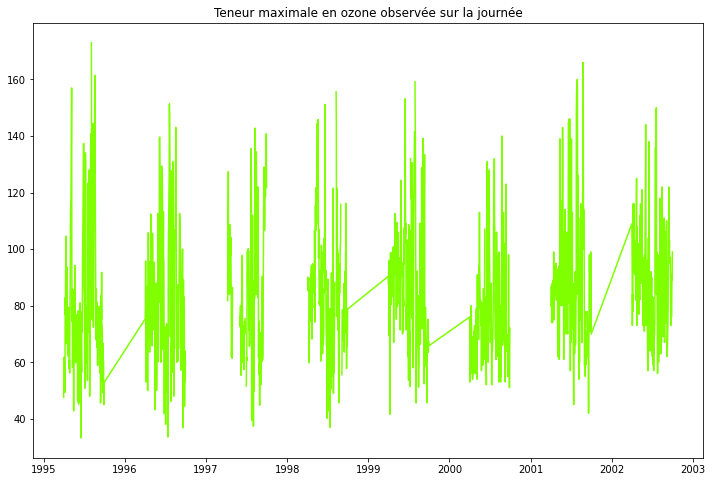

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df2['maxO3'], color='chartreuse')
plt.title('Teneur maximale en ozone observée sur la journée')
plt.show()

On s'aperçoit que les donnée manquantes sont regroupées entre elles (représentées ci-dessus par des traits distincts). Ces données manquantes se situent toujours au même moment des différentes années.

Nous allons commencer par calculer le pourcentage de valeurs manquantes dans chaque variable.

In [ ]:
missing_values = df2.isna().sum().to_dict()
print(missing_values)


{'maxO3': 73, 'T6': 1, 'T9': 1, 'T12': 1, 'T15': 1, 'T18': 1, 'Ne6': 2, 'Ne9': 2, 'Ne12': 2, 'Ne15': 2, 'Ne18': 5, 'Vdir6': 1, 'Vvit6': 1, 'Vdir9': 1, 'Vvit9': 1, 'Vdir12': 1, 'Vvit12': 1, 'Vdir15': 1, 'Vvit15': 1, 'Vdir18': 1, 'Vvit18': 1, 'Vx': 1, 'maxO3v': 73}


Les valeurs manquantes sont donc majoritairement liées à la variable dépendante de notre modèle. Comme il s'agit d'une série temporelle, nous devons d'abord voir s'il y a une saisonnalité afin de savoir comment nous allons imputer ces valeurs manquantes.

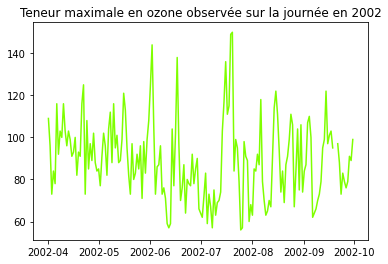

In [ ]:
df2_2002 = df2[df2.index.year == 2002]

plt.plot(df2_2002['maxO3'], color='chartreuse')
plt.title('Teneur maximale en ozone observée sur la journée en 2002')
plt.show()

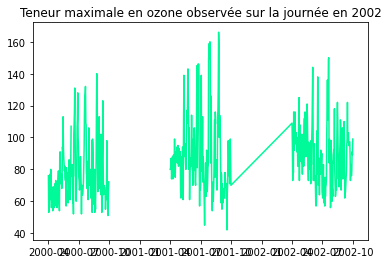

In [ ]:
df2_2002_2001_2000 = df2[(df2.index.year == 2002) | (df2.index.year == 2001) | (df2.index.year == 2000) ]
plt.plot(df2_2002_2001_2000['maxO3'], color='mediumspringgreen')
plt.title('Teneur maximale en ozone observée sur la journée en 2002')
plt.show()

Sur 1 an, nous ne voyons pas de saisonnalité ou de tendances, ni même sur plusieurs années en "zoomant" un peu sur nos données. Par logique, nous supposons qu'il y en a par jour mais nous ne pouvons pas être plus précis que les données journalières.

Nous allons maintenant faire un traçage par saison, nous supposons qu'il y a davantage de production en hiver pour des questions de chauffage.

In [ ]:
import calendar
df2_spring = df2[df2.index.month.isin([3,4,5])]
df2_summer = df2[df2.index.month.isin([6,7,8])]
df2_fall = df2[df2.index.month.isin([9,10,11])]
df2_winter = df2[df2.index.month.isin([12,1,2])]

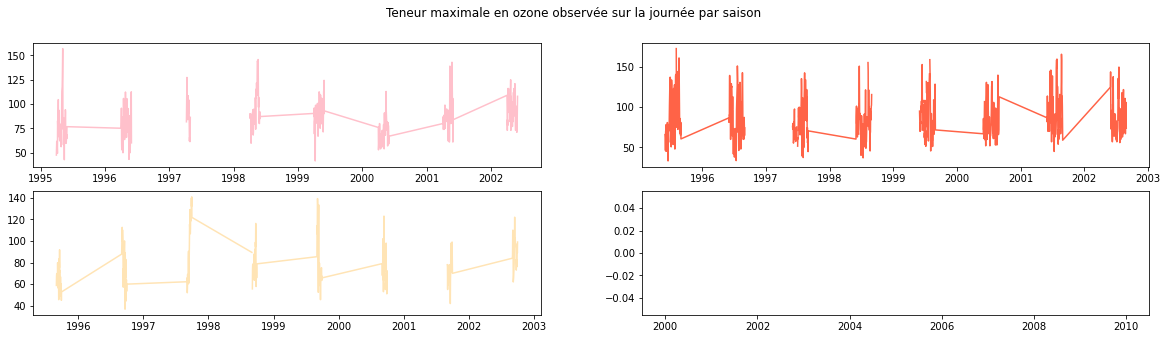

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 5))

ax[0,0].plot(df2_spring['maxO3'], color='pink')
ax[0,1].plot(df2_summer['maxO3'], color='tomato')
ax[1,0].plot(df2_fall['maxO3'], color='moccasin')
ax[1,1].plot(df2_winter['maxO3'], color='deepskyblue')
plt.suptitle('Teneur maximale en ozone observée sur la journée par saison')
plt.show()

Nous nous apercevons que les données temporelles qui sont ne sont pas disponibles dans la base de donnée correspondent à la saison **hivernale**. Mais ceci n'est pas très grave ici car nous cherchons à prédire la teneur en ozone à horizon d'un jour en automne. Il faudrait noter que notre modèle ne sera pas adapté pour prédire la teneur en ozone un jour d'hiver.

Pour les séries temporelles, les méthodes classiques d'imputation ne fonctionnent pas (médiane, moyenne, random etc).
On peut alors utiliser plusieurs techniques :
* '**ffill**' or 'pad' - Remplace les NaN s avec la dernière valeur observée
* '**bfill**' or 'backfill' - Remplace les NaN s avec la prochaine valeur observée
* **Linear interpolation method**

L'interpolation linéaire est une technique d'imputation qui suppose une relation linéaire entre les points de données et utilise les valeurs non manquantes des points de données adjacents pour calculer une valeur pour un point de données manquant.


Il existe également des techniques plus avancées :

* K-Nearest Neighbor Imputation : La classe KNNImputer permet d'imputer les valeurs manquantes à l'aide de l'approche des k-proches voisins.
* Multivariate feature imputation : Stratégie d'imputation des valeurs manquantes qui consiste à modéliser chaque caractéristique présentant des valeurs manquantes en fonction d'autres caractéristiques.

C'est ce que nous utiliserons pour maxO3 et maxO3v, les k-nearest neighbors.

In [ ]:
df2_copy = df2.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
df2_copy['maxO3'] = knn_imputer.fit_transform(df2_copy[['maxO3']])

In [ ]:
df2_copy['maxO3'].isnull().sum()

0

Nous allons maintenant remplacer les valeurs manquantes de maxO3 par les valeurs de maxO3 de la veille.

In [ ]:
df2_copy['maxO3v'] = df2_copy['maxO3v'].fillna(df2_copy['maxO3'].shift(1))

Pour les autres variables où il y avait des valeurs manquantes, puisqu'il y en avait moins d'1%, nous pouvons utiliser la méthode de l'interpolation linéraire, car on les suppose linéraire.

In [ ]:
df2_copy['T6'].interpolate(method='linear', inplace=True)
df2_copy['T9'].interpolate(method='linear', inplace=True)
df2_copy['T12'].interpolate(method='linear', inplace=True)
df2_copy['T15'].interpolate(method='linear', inplace=True)
df2_copy['T18'].interpolate(method='linear', inplace=True)
df2_copy['Ne6'].interpolate(method='linear', inplace=True)
df2_copy['Ne9'].interpolate(method='linear', inplace=True)
df2_copy['Ne12'].interpolate(method='linear', inplace=True)
df2_copy['Ne15'].interpolate(method='linear', inplace=True)
df2_copy['Ne18'].interpolate(method='linear', inplace=True)
df2_copy['Vdir6'].interpolate(method='linear', inplace=True)
df2_copy['Vvit6'].interpolate(method='linear', inplace=True)
df2_copy['Vdir9'].interpolate(method='linear', inplace=True)
df2_copy['Vvit9'].interpolate(method='linear', inplace=True)
df2_copy['Vdir12'].interpolate(method='linear', inplace=True)
df2_copy['Vvit12'].interpolate(method='linear', inplace=True)
df2_copy['Vdir15'].interpolate(method='linear', inplace=True)
df2_copy['Vvit15'].interpolate(method='linear', inplace=True)
df2_copy['Vdir18'].interpolate(method='linear', inplace=True)
df2_copy['Vvit18'].interpolate(method='linear', inplace=True)
df2_copy['Vx'].interpolate(method='linear', inplace=True)

In [ ]:
missing_values_copy = df2_copy.isna().sum().to_dict()
print(missing_values_copy)

{'maxO3': 0, 'T6': 0, 'T9': 0, 'T12': 0, 'T15': 0, 'T18': 0, 'Ne6': 0, 'Ne9': 0, 'Ne12': 0, 'Ne15': 0, 'Ne18': 0, 'Vdir6': 0, 'Vvit6': 0, 'Vdir9': 0, 'Vvit9': 0, 'Vdir12': 0, 'Vvit12': 0, 'Vdir15': 0, 'Vvit15': 0, 'Vdir18': 0, 'Vvit18': 0, 'Vx': 0, 'maxO3v': 0}


Il n'y a plus de valeurs manquantes. Nous pouvons commencer à regarder si la série temporelle est stationnaire, même si on le suppose.

In [ ]:
df2_copy['day_of_week'] = df2_copy.index.day_name()

Text(0.5, 1.0, 'Teneur maximale en ozone observée sur la journée par jour de la semaine')

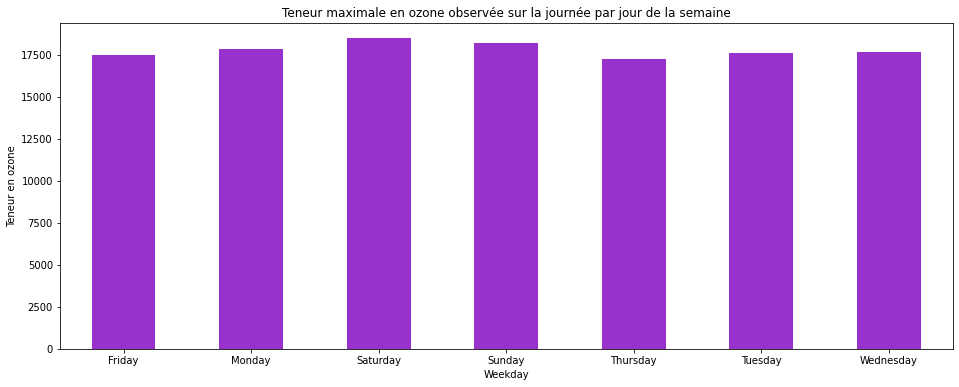

In [ ]:
df2_copy.groupby(['day_of_week']).sum()['maxO3'].plot(figsize=(16,6), kind='bar', color = 'darkorchid', rot=0)
plt.xlabel("Weekday")
plt.ylabel("Teneur en ozone")
plt.title("Teneur maximale en ozone observée sur la journée par jour de la semaine")

Même selon les jours de la semaine, nous n'observons pas de différences flagrantes.

## Analyse de la stationnarité

In [ ]:
df2_acf = df2_copy.copy()
df2_acf  = df2_acf[['maxO3']]
df2_acf.index.names = ['Date']
df2_acf

,maxO3
Date,
1995-04-01,47.6
1995-04-02,56.2
1995-04-03,61.8
1995-04-04,50.8
1995-04-05,59.8
...,...
2002-09-26,76.0
2002-09-27,79.0
2002-09-28,91.0


In [ ]:
# Test de Dickey-Fuller
result_df2 = stattools.adfuller(df2_acf["maxO3"])

# Résultats du test
print('Statistique de test : ', result_df2[0])
print('p-valeur : ', result_df2[1])
print('Nombre de lags : ', result_df2[2])
print('Nombre de observations utilisées : ', result_df2[3])
print('Critères d’arrêt : ', result_df2[4])

# Interprétation des résultats
alpha = 0.05
if result_df2[1] < alpha:
    print("On rejette l'hypothèse nulle, la série temporelle est stationnaire")
else:
    print("On ne peut pas rejeter l'hypothèse nulle, la série temporelle n'est pas stationnaire")

Statistique de test :  -17.44876721369324
p-valeur :  4.6653703522258726e-30
Nombre de lags :  0
Nombre de observations utilisées :  1463
Critères d’arrêt :  {'1%': -3.434827656046504, '5%': -2.86351758903648, '10%': -2.5678228503262757}
On rejette l'hypothèse nulle, la série temporelle est stationnaire


Ici, le test d'ADF rejette l'hypothèse nulle que la série présente une racine unitaire et retient l'hypothèse alternative qu'elle est stationnaire. Mais seulement dans le sens de la racine unitaire.
Nous allons maintenant analyser la stationnarité avec l'ACF.

In [ ]:
N = len(df2_acf)
m = 1
nlag_max = round(10*math.log10(N/m), 0)
nlag_max

32.0

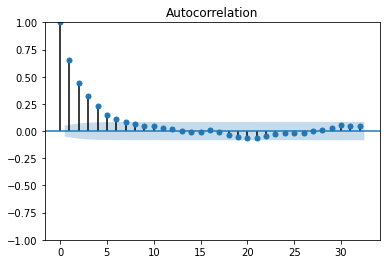

In [ ]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(df2_acf['maxO3'], lags=nlag_max, ax=ax)
plt.show()


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



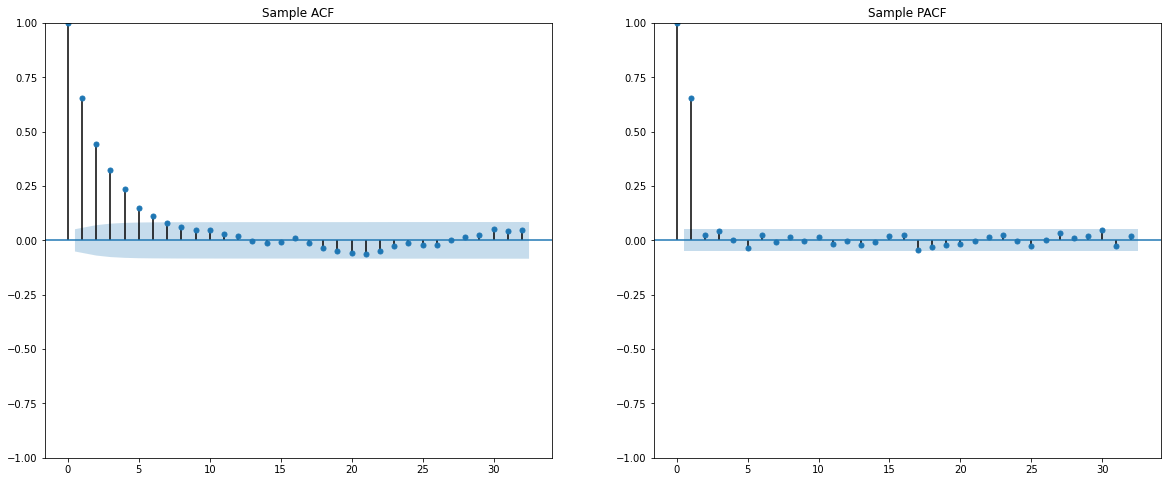

In [ ]:
def plot_acf_pacf(series, nlags):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sm.graphics.tsa.plot_acf(series, lags=nlags, ax = axes[0])
    axes[0].set_title('Sample ACF')

    sm.graphics.tsa.plot_pacf(series, lags=nlags, ax = axes[1])
    axes[1].set_title('Sample PACF')

    return fig

fig = plot_acf_pacf(df2_acf, nlags= nlag_max)
plt.show(fig)

On observe que le graphique de l'ACF qu'elle décroît rapidement vers 0 en sinusoïdale amortie, cela indique qu'elle est stationnaire, de plus la PACF est considérée comme nulle. Ce dernier graphique nous suggère un **ARMA(1,0)** car on observe une forte autocorrélation au lag 1, et ensuite nulle.
L'autocorréloggrame simple est nul après le lag 6, ce qui suggère un modèle **ARMA(0,6)**.

## Modèles sans pic d'ozone de la veille

Dans cette sous-partie nous allons explorer différents modèles en ne prenant pas en compte la variable maxO3v.

In [ ]:
split_date  =datetime.strptime('2002-01-01', '%Y-%m-%d')
df2meteo = df2_copy.drop('maxO3v', axis = 1)
df2meteo_train = df2meteo.loc[df2meteo.index < split_date]
df2meteo_test = df2meteo.loc[df2meteo.index >= split_date]

df2meteo_test

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,day_of_week
2002-04-01,109.0,7.8,10.4,14.7,15.3,14.3,8.0,6.0,6.0,5.0,...,160.0,2.0,230.0,4.0,270.0,2.0,220.0,1.0,-3.0642,Monday
2002-04-02,96.0,7.7,11.0,18.3,19.7,18.1,7.0,5.0,7.0,2.0,...,120.0,3.0,140.0,4.0,160.0,7.0,200.0,5.0,2.5712,Tuesday
2002-04-03,73.0,11.0,11.9,13.8,11.7,11.4,8.0,8.0,8.0,8.0,...,140.0,2.0,80.0,1.0,100.0,3.0,30.0,2.0,0.9848,Wednesday
2002-04-04,84.0,9.9,10.6,14.6,15.5,13.0,7.0,7.0,5.0,3.0,...,300.0,2.0,300.0,5.0,320.0,5.0,320.0,4.0,-4.3301,Thursday
2002-04-05,78.0,6.8,8.6,12.9,13.9,12.5,8.0,8.0,7.0,6.0,...,110.0,3.0,160.0,3.0,210.0,3.0,160.0,1.0,1.0261,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-09-26,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,Thursday
2002-09-27,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,Friday
2002-09-28,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,Saturday
2002-09-29,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,Sunday


### Modèle 1 : Prophet

Le modèle Prophet attends que le dataset soit paramétré de manière spécifique. Nous allons donc renommer nos colonnes.

In [ ]:
df2meteo_train_prophet = df2meteo_train.assign(ds=df2meteo_train.index)
df2meteo_train_prophet = df2meteo_train_prophet.reset_index(drop=True)

df2meteo_test_prophet = df2meteo_test.assign(ds=df2meteo_test.index)
df2meteo_test_prophet = df2meteo_test_prophet.reset_index(drop=True)

df2meteo_train_prophet

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,day_of_week,ds
0,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,Saturday,1995-04-01
1,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,Sunday,1995-04-02
2,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,Monday,1995-04-03
3,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,Tuesday,1995-04-04
4,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,Wednesday,1995-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,71.0,15.6,16.6,18.0,18.5,16.8,8.0,7.0,7.0,7.0,...,4.0,250.0,5.0,220.0,5.0,220.0,5.0,-4.6985,Wednesday,2001-09-26
1277,77.0,13.5,16.2,20.8,22.1,20.0,8.0,6.0,5.0,5.0,...,4.0,210.0,4.0,200.0,4.0,170.0,1.0,-2.0000,Thursday,2001-09-27
1278,99.0,11.7,16.9,23.0,22.6,18.9,6.0,6.0,4.0,7.0,...,3.0,170.0,5.0,170.0,5.0,160.0,2.0,0.8682,Friday,2001-09-28
1279,83.0,16.2,16.9,19.8,22.1,18.1,8.0,6.0,5.0,3.0,...,4.0,290.0,4.0,270.0,4.0,240.0,3.0,-3.7588,Saturday,2001-09-29


In [ ]:
df2meteo_train_prophet = df2meteo_train_prophet.rename(columns={'maxO3': 'y'})

df2meteo_test_prophet = df2meteo_test_prophet.rename(columns={'maxO3': 'y'})

In [ ]:
# Modèle d'entrainement puis on le fit
modelmeteo = Prophet()
modelmeteo.fit(df2meteo_train_prophet.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rrozavm/osvw6xvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rrozavm/jam7bwy6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3423', 'data', 'file=/tmp/tmp4rrozavm/osvw6xvn.json', 'init=/tmp/tmp4rrozavm/jam7bwy6.json', 'output', 'file=/tmp/tmp4rrozavm/prophet_model8238qgt4/prophet_model-20230219172017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Prédiction sur le set train
df2meteo_test_fcst = modelmeteo.predict(df=df2meteo_test_prophet.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

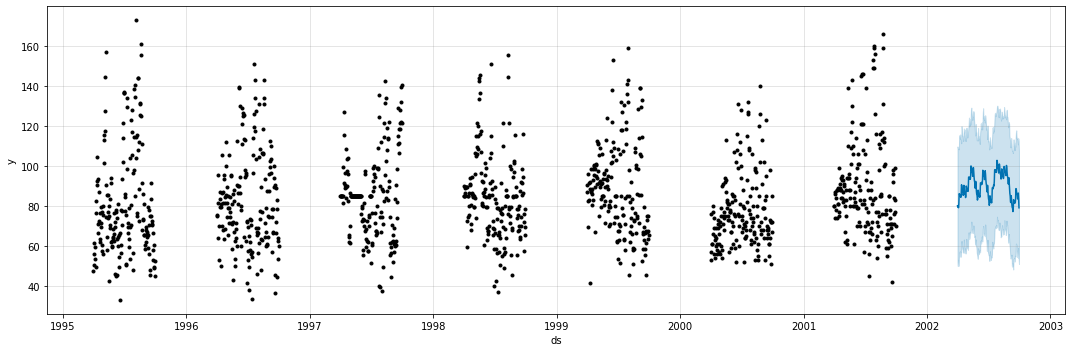

In [ ]:
# Tracer les prévisions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = modelmeteo.plot(df2meteo_test_fcst,
                 ax=ax)
plt.show()

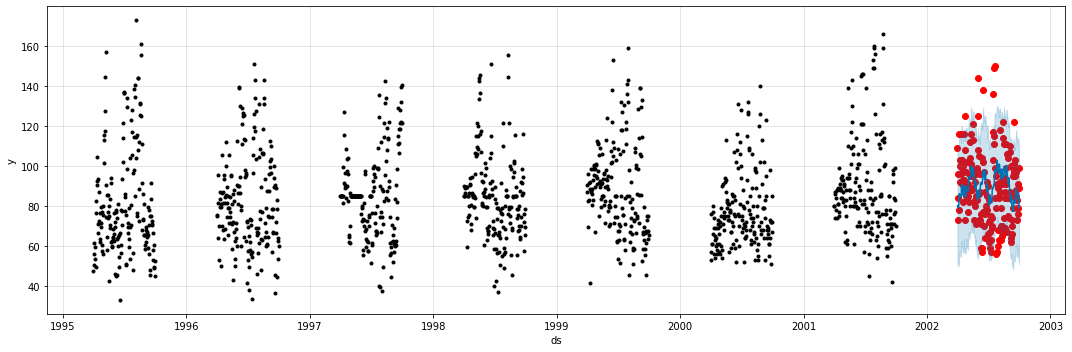

In [ ]:
# Plot les prévisions avec la réalité
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df2meteo_test.index, df2meteo_test_prophet['y'], color='r')
fig = modelmeteo.plot(df2meteo_test_fcst, ax=ax)

In [ ]:
df2meteo_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-04-01,78.060605,51.818636,109.935825,78.060605,78.060605,2.108091,2.108091,2.108091,0.118285,0.118285,0.118285,1.989806,1.989806,1.989806,0.0,0.0,0.0,80.168696
1,2002-04-02,78.068852,50.090519,109.238110,78.068852,78.068852,1.643579,1.643579,1.643579,-0.733253,-0.733253,-0.733253,2.376831,2.376831,2.376831,0.0,0.0,0.0,79.712430
2,2002-04-03,78.077098,53.223013,108.742007,78.077098,78.077098,2.305933,2.305933,2.305933,-0.619915,-0.619915,-0.619915,2.925848,2.925848,2.925848,0.0,0.0,0.0,80.383032
3,2002-04-04,78.085345,50.150972,108.861702,78.085345,78.085345,1.191161,1.191161,1.191161,-2.408127,-2.408127,-2.408127,3.599288,3.599288,3.599288,0.0,0.0,0.0,79.276506
4,2002-04-05,78.093591,53.043281,108.486897,78.093591,78.093591,2.906574,2.906574,2.906574,-1.452030,-1.452030,-1.452030,4.358604,4.358604,4.358604,0.0,0.0,0.0,81.000165


In [ ]:
msemeteo_prophet = mean_squared_error(y_true=df2meteo_test_prophet['y'],
                   y_pred=df2meteo_test_fcst['yhat'])
msemeteo_prophet

366.56123998052794

In [ ]:
from math import sqrt

rmsemeteo_prophet = sqrt(msemeteo_prophet)
rmsemeteo_prophet

19.145789092657633

### Modèle 2 : XGBOOST

In [ ]:
df2meteo_train = df2meteo_train.drop("day_of_week", axis = 1)
df2meteo_test = df2meteo_test.drop("day_of_week", axis = 1)

In [ ]:
df2meteo_test

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vvit6,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx
2002-04-01,109.0,7.8,10.4,14.7,15.3,14.3,8.0,6.0,6.0,5.0,...,0.0,160.0,2.0,230.0,4.0,270.0,2.0,220.0,1.0,-3.0642
2002-04-02,96.0,7.7,11.0,18.3,19.7,18.1,7.0,5.0,7.0,2.0,...,0.0,120.0,3.0,140.0,4.0,160.0,7.0,200.0,5.0,2.5712
2002-04-03,73.0,11.0,11.9,13.8,11.7,11.4,8.0,8.0,8.0,8.0,...,3.0,140.0,2.0,80.0,1.0,100.0,3.0,30.0,2.0,0.9848
2002-04-04,84.0,9.9,10.6,14.6,15.5,13.0,7.0,7.0,5.0,3.0,...,3.0,300.0,2.0,300.0,5.0,320.0,5.0,320.0,4.0,-4.3301
2002-04-05,78.0,6.8,8.6,12.9,13.9,12.5,8.0,8.0,7.0,6.0,...,2.0,110.0,3.0,160.0,3.0,210.0,3.0,160.0,1.0,1.0261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-09-26,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,2.0,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000
2002-09-27,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,1.0,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660
2002-09-28,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,1.0,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641
2002-09-29,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,2.0,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302


In [ ]:
X_train = df2meteo_train.drop('maxO3', axis=1)
y_train = df2meteo_train['maxO3']

X_test = df2meteo_test.drop('maxO3', axis=1)
y_test = df2meteo_test['maxO3']

In [ ]:
Y = df2meteo['maxO3']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier


# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y_train = label_encoder.transform(y_train)

param_grid = {'max_depth':[1, 2], 'gamma':[0, 0.5, 1], 'n_estimators':[100, 200], 'learning_rate':[0.05, 0.1]}

optimal_params = GridSearchCV(
        XGBClassifier(seed='12345'),
        param_grid,
        cv=5,
        verbose=2 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(X_train,label_encoded_y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=100; total time=  48.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=100; total time=  29.6s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=100; total time=  29.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=100; total time=  31.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=100; total time=  29.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=200; total time=  58.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=200; total time=  58.6s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=200; total time=  58.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=200; total time=  56.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=1, n_estimators=200; total time=  58.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, n_estimators=100; total time=  38.0s
[CV] END gamma=0, learning_rate=

Nous n'utiliserons pas la cross-validation pour choisir nos paramètres car les paramètres testés ci-dessous n'ont pas eu un résultat concluant par rapport aux modèles finetuné à la main, il faudrait pouvoir utiliser la crossvalidation avec davantages de paramètres cependant cela s'avèrerait très chronophage pour le peu que cela nous apporterait (ici la CV a tourné pendant 1h30).

In [ ]:
 #{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100}

import time
ts = time.time()

model = XGBRegressor(max_depth= 4, gamma= 15, n_estimators=1000, learning_rate=0.1, random_state=42)

model.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True,
    early_stopping_rounds = 100)

time.time() - ts

[17:20:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:78.7397	validation_1-rmse:82.5623
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:71.2308	validation_1-rmse:75.2215
[2]	validation_0-rmse:64.4955	validation_1-rmse:68.6153
[3]	validation_0-rmse:58.4613	validation_1-rmse:62.7692
[4]	validation_0-rmse:53.0535	validation_1-rmse:57.4836
[5]	validation_0-rmse:48.2093	validation_1-rmse:52.779
[6]	validation_0-rmse:43.8806	validation_1-rmse:48.5483
[7]	validation_0-rmse:40.0159	validation_1-rmse:44.7477
[8]	validation_0-rmse:36.5736	validation_1-rmse:41.3457
[9]	validation_0-rmse:33.4992	validation_1-rmse:38.3675
[10]	validation_0-rmse:30.7822	validation_1-rmse:35.6682
[11]	validation_0-rmse:28.3615	validation_1-rmse:33.3115
[12]	validation_0-rmse:26.2216	validatio

2.421430826187134

In [ ]:
#predicting validation data.
predmeteo=model.predict(X_test)

In [ ]:
# Calculate the MSE
msemeteo_xgboost = mean_squared_error(y_test, predmeteo)

# Print the MSE
print("MSE: ", msemeteo_xgboost)


MSE:  219.1463944937652


In [ ]:
rmsemeteo_xgboost = sqrt(msemeteo_xgboost)
rmsemeteo_xgboost

14.803593972200305

In [ ]:
# Sélection de la dernière prévision du modèle
predictionsmeteo_1 = predmeteo[-1:]
predictionsmeteo_1

array([92.27561], dtype=float32)

In [ ]:
# Sélection de la dernière valeur réelle de votre série temporelle
y_testmeteo_1 = y_test[-1:]

# Calcul du MSE
msemeteo_1 = mean_squared_error(y_testmeteo_1, predictionsmeteo_1)
msemeteo_1

45.21739562280709

In [ ]:
rmsemeteo_xgboost_1 = sqrt(msemeteo_1)
rmsemeteo_xgboost_1

6.724388122558594

Ici, le RMSE pour la prévision du taux d'ozone à horizon d'un jour est de 1.89,

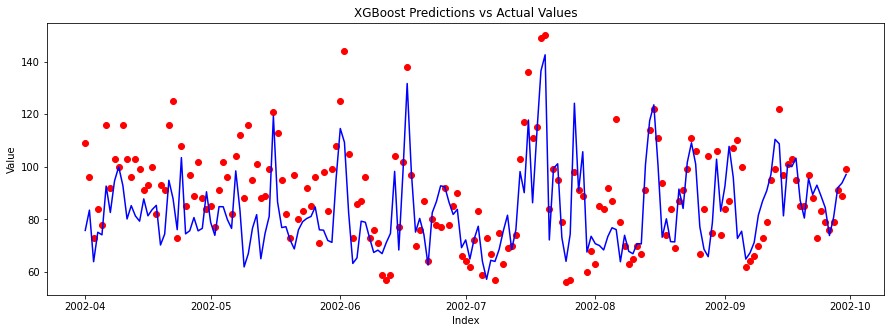

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(y_test.index, y_test, color='r')
ax.plot(y_test.index, predmeteo, color='b')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('XGBoost Predictions vs Actual Values')
plt.show()

Le modèle XGBoost sur les données sans le pic d'ozone a tendance a surestimé le taux d'ozone prédit, cependant dans l'ensemble, elles sont cohérentes.

## Modèles avec pic d'ozone de la veille

Nous allons effectué notre prédiction avec un modèle ARMA.

In [ ]:
split_date = datetime.strptime('2002-01-01', '%Y-%m-%d')
df2_train = df2_copy.loc[df2_copy.index < split_date]
df2_test = df2_copy.loc[df2_copy.index >= split_date]

df2_test

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v,day_of_week
2002-04-01,109.0,7.8,10.4,14.7,15.3,14.3,8.0,6.0,6.0,5.0,...,2.0,230.0,4.0,270.0,2.0,220.0,1.0,-3.0642,111.0,Monday
2002-04-02,96.0,7.7,11.0,18.3,19.7,18.1,7.0,5.0,7.0,2.0,...,3.0,140.0,4.0,160.0,7.0,200.0,5.0,2.5712,109.0,Tuesday
2002-04-03,73.0,11.0,11.9,13.8,11.7,11.4,8.0,8.0,8.0,8.0,...,2.0,80.0,1.0,100.0,3.0,30.0,2.0,0.9848,96.0,Wednesday
2002-04-04,84.0,9.9,10.6,14.6,15.5,13.0,7.0,7.0,5.0,3.0,...,2.0,300.0,5.0,320.0,5.0,320.0,4.0,-4.3301,73.0,Thursday
2002-04-05,78.0,6.8,8.6,12.9,13.9,12.5,8.0,8.0,7.0,6.0,...,3.0,160.0,3.0,210.0,3.0,160.0,1.0,1.0261,84.0,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-09-26,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0,Thursday
2002-09-27,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0,Friday
2002-09-28,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0,Saturday
2002-09-29,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0,Sunday


### Modèle 1 : Prophet

Le modèle Prophet attends que le dataset soit paramétré de manière spécifique. Nous allons donc renommer nos colonnes.

In [ ]:
df2_train_prophet = df2_train.assign(ds=df2_train.index)
df2_train_prophet = df2_train_prophet.reset_index(drop=True)

df2_test_prophet = df2_test.assign(ds=df2_test.index)
df2_test_prophet = df2_test_prophet.reset_index(drop=True)

df2_train_prophet

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v,day_of_week,ds
0,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2,Saturday,1995-04-01
1,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6,Sunday,1995-04-02
2,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2,Monday,1995-04-03
3,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8,Tuesday,1995-04-04
4,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8,Wednesday,1995-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,71.0,15.6,16.6,18.0,18.5,16.8,8.0,7.0,7.0,7.0,...,250.0,5.0,220.0,5.0,220.0,5.0,-4.6985,84.0,Wednesday,2001-09-26
1277,77.0,13.5,16.2,20.8,22.1,20.0,8.0,6.0,5.0,5.0,...,210.0,4.0,200.0,4.0,170.0,1.0,-2.0000,71.0,Thursday,2001-09-27
1278,99.0,11.7,16.9,23.0,22.6,18.9,6.0,6.0,4.0,7.0,...,170.0,5.0,170.0,5.0,160.0,2.0,0.8682,77.0,Friday,2001-09-28
1279,83.0,16.2,16.9,19.8,22.1,18.1,8.0,6.0,5.0,3.0,...,290.0,4.0,270.0,4.0,240.0,3.0,-3.7588,99.0,Saturday,2001-09-29


In [ ]:
df2_train_prophet = df2_train_prophet.rename(columns={'maxO3': 'y'})

df2_test_prophet = df2_test_prophet.rename(columns={'maxO3': 'y'})

df2_train_prophet

,y,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v,day_of_week,ds
0,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2,Saturday,1995-04-01
1,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6,Sunday,1995-04-02
2,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2,Monday,1995-04-03
3,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8,Tuesday,1995-04-04
4,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8,Wednesday,1995-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,71.0,15.6,16.6,18.0,18.5,16.8,8.0,7.0,7.0,7.0,...,250.0,5.0,220.0,5.0,220.0,5.0,-4.6985,84.0,Wednesday,2001-09-26
1277,77.0,13.5,16.2,20.8,22.1,20.0,8.0,6.0,5.0,5.0,...,210.0,4.0,200.0,4.0,170.0,1.0,-2.0000,71.0,Thursday,2001-09-27
1278,99.0,11.7,16.9,23.0,22.6,18.9,6.0,6.0,4.0,7.0,...,170.0,5.0,170.0,5.0,160.0,2.0,0.8682,77.0,Friday,2001-09-28
1279,83.0,16.2,16.9,19.8,22.1,18.1,8.0,6.0,5.0,3.0,...,290.0,4.0,270.0,4.0,240.0,3.0,-3.7588,99.0,Saturday,2001-09-29


In [ ]:
# Modèle d'entrainement puis on le fit
model = Prophet()
model.fit(df2_train_prophet.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rrozavm/v4vt54gc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rrozavm/n3mcxa1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28890', 'data', 'file=/tmp/tmp4rrozavm/v4vt54gc.json', 'init=/tmp/tmp4rrozavm/n3mcxa1d.json', 'output', 'file=/tmp/tmp4rrozavm/prophet_modelghc3ysg2/prophet_model-20230219172106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Predict on training set with model
df2_test_fcst = model.predict(df=df2_test_prophet.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

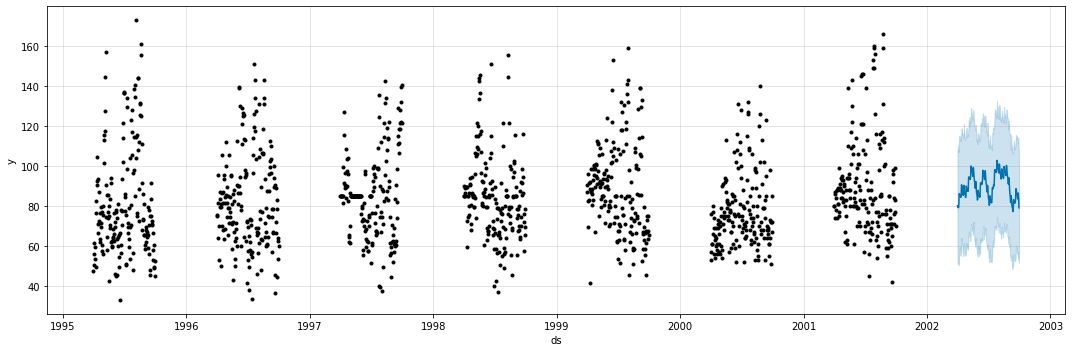

In [ ]:
# Tracer les prévisions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df2_test_fcst,
                 ax=ax)
plt.show()

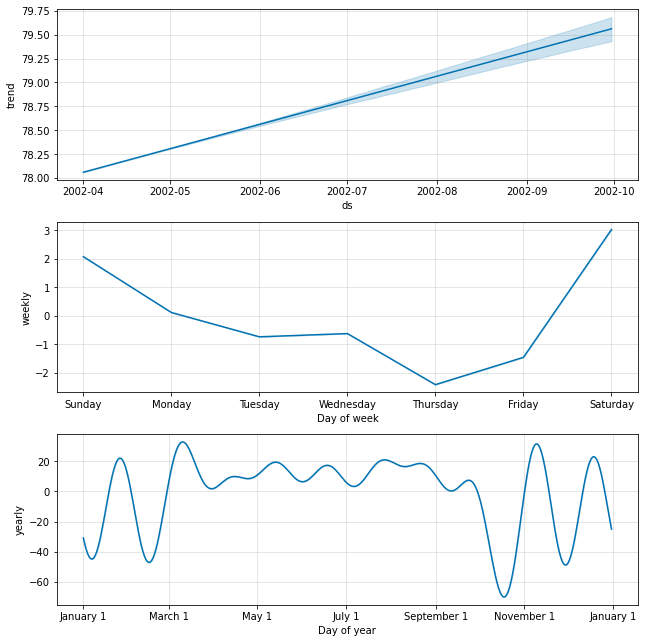

In [ ]:
# Plot the components of the model
fig = model.plot_components(df2_test_fcst)

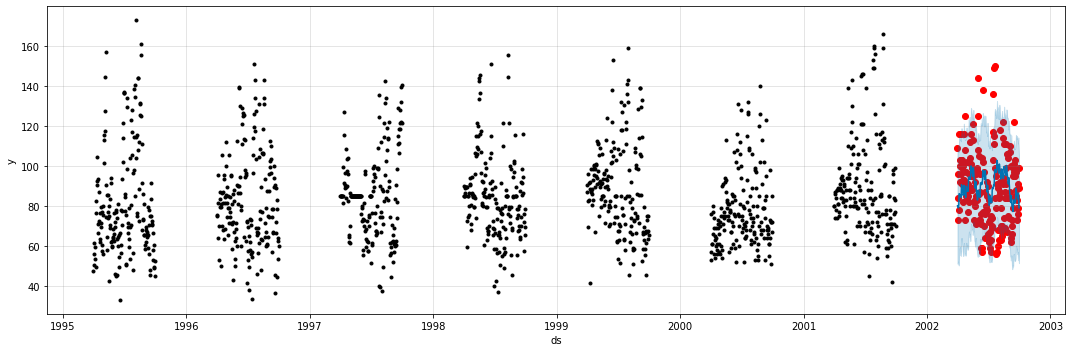

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df2_test.index, df2_test_prophet['y'], color='r')
fig = model.plot(df2_test_fcst, ax=ax)

In [ ]:
df2_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-04-01,78.060605,51.280656,107.687705,78.060605,78.060605,2.108091,2.108091,2.108091,0.118285,0.118285,0.118285,1.989806,1.989806,1.989806,0.0,0.0,0.0,80.168696
1,2002-04-02,78.068852,51.367248,108.717345,78.068852,78.068852,1.643579,1.643579,1.643579,-0.733253,-0.733253,-0.733253,2.376831,2.376831,2.376831,0.0,0.0,0.0,79.712430
2,2002-04-03,78.077098,52.288339,110.525163,78.077098,78.077098,2.305933,2.305933,2.305933,-0.619915,-0.619915,-0.619915,2.925848,2.925848,2.925848,0.0,0.0,0.0,80.383032
3,2002-04-04,78.085345,51.020575,107.110526,78.085345,78.085345,1.191161,1.191161,1.191161,-2.408127,-2.408127,-2.408127,3.599288,3.599288,3.599288,0.0,0.0,0.0,79.276506
4,2002-04-05,78.093591,50.415194,109.580749,78.093591,78.093591,2.906574,2.906574,2.906574,-1.452030,-1.452030,-1.452030,4.358604,4.358604,4.358604,0.0,0.0,0.0,81.000165


In [ ]:
mse_prophet = mean_squared_error(y_true=df2_test_prophet['y'],
                   y_pred=df2_test_fcst['yhat'])
mse_prophet

366.56123998052794

In [ ]:
from math import sqrt

rmse_prophet = sqrt(mse_prophet)
rmse_prophet

19.145789092657633

Nous comparerons ce score avec celui d'autres modèles.

### Modèle 2 : XGBOOST

In [ ]:
df2_train = df2_train.drop("day_of_week", axis = 1)
df2_test = df2_test.drop("day_of_week", axis = 1)

In [ ]:
X_train_avec = df2_train.drop('maxO3', axis=1)
y_train_avec = df2_train['maxO3']

X_test_avec = df2_test.drop('maxO3', axis=1)
y_test_avec = df2_test['maxO3']

In [ ]:
import time
ts = time.time()

modelXG = XGBRegressor(max_depth= 4, gamma= 15, n_estimators=1000, learning_rate=0.1, random_state=42)

modelXG.fit(
    X_train_avec,
    y_train_avec,
    eval_metric="rmse",
    eval_set=[(X_train_avec, y_train_avec), (X_test_avec, y_test_avec)],
    verbose=True,
    early_stopping_rounds = 100)

time.time() - ts

[17:21:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:78.7011	validation_1-rmse:82.3261
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:71.1491	validation_1-rmse:74.7853
[2]	validation_0-rmse:64.3673	validation_1-rmse:68.0453
[3]	validation_0-rmse:58.2782	validation_1-rmse:61.9451
[4]	validation_0-rmse:52.8152	validation_1-rmse:56.5082
[5]	validation_0-rmse:47.9205	validation_1-rmse:51.6461
[6]	validation_0-rmse:43.5234	validation_1-rmse:47.1718
[7]	validation_0-rmse:39.5943	validation_1-rmse:43.2123
[8]	validation_0-rmse:36.0822	validation_1-rmse:39.6747
[9]	validation_0-rmse:32.9461	validation_1-rmse:36.5214
[10]	validation_0-rmse:30.1427	validation_1-rmse:33.727
[11]	validation_0-rmse:27.6504	validation_1-rmse:31.2195
[12]	validation_0-rmse:25.4244	validatio

0.9418790340423584

In [ ]:
#predicting validation data.
predxg=modelXG.predict(X_test_avec)

# Calcul du MSE et RMSE
mse_xgboost = mean_squared_error(y_test_avec, predxg)
rmse_xgboost = sqrt(mse_xgboost)

print("MSE: ", mse_xgboost)
print("RMSE: ", rmse_xgboost)

MSE:  141.73381678893873
RMSE:  11.905201249409382


In [ ]:
# Sélection de la dernière prévision du modèle
predxg_1 = predxg[-1:]

# Sélection de la dernière valeur réelle de la série temporelle
y_test_1 = y_test_avec[-1:]

# Calcul le MSE
mse_1 = mean_squared_error(y_test_1, predxg_1)

#Calcul du RMSE
rmse_xgboost_1 = sqrt(mse_1)
print("MSE: ", mse_1)
print("RMSE: ", rmse_xgboost_1)

MSE:  4.066712632833514
RMSE:  2.0166091918945312


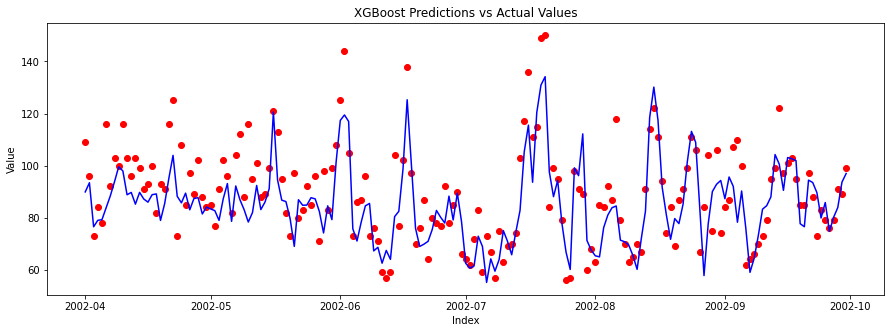

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(y_test_avec.index, y_test_avec, color='r')
ax.plot(y_test_avec.index, predxg, color='b')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('XGBoost Predictions vs Actual Values')
plt.show()


Le modèle XGBoost sur les données avec le pic d'ozone a tendance a surestimé le taux d'ozone prédit, cependant dans l'ensemble, elles sont cohérentes.

## Analyse des bruits blancs

Il nous fallait d'abord déterminer quel était le modèle le plus efficace afin d'ensuite analyser ses résidus, même si ce n'est pas dans ce sens que l'on fait habituellement.

In [ ]:
residuals_xg = y_test_avec - predxg

from statsmodels.stats.diagnostic import acorr_ljungbox

_, p_value = acorr_ljungbox(residuals_xg, boxpierce=False)

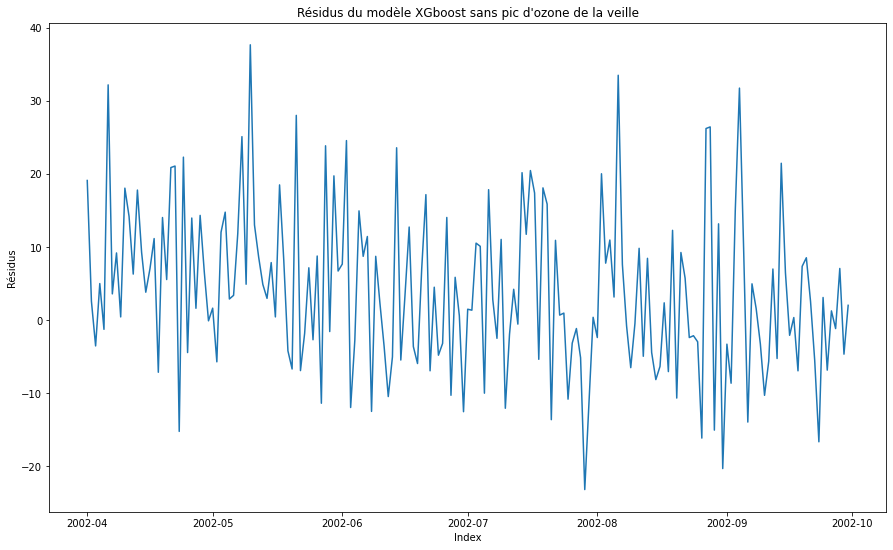

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(residuals_xg)
plt.title("Résidus du modèle XGboost sans pic d'ozone de la veille")
plt.xlabel("Index")
plt.ylabel("Résidus")
plt.show()

Les résidus sont aléatoires, ce qui indique généralement un bon modèle de prédiction.

Ici, nous allons effectuer un test de Shapiro-Walk. Si la p-value est inférieure au seuil 0,05, on peut rejeter l'hypothèse d'une distribution normale pour les données.

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(residuals_xg)
print("Test statistique : ", stat)
print("p-value : ", p)

Test statistique :  0.988539457321167
p-value :  0.1464548408985138


On peut voir que la p-value est supérieure à 0.05 (0.1), la distribution des résidus  du modèle XGboost sans pic d'ozone de la veille n'est donc pas normale.

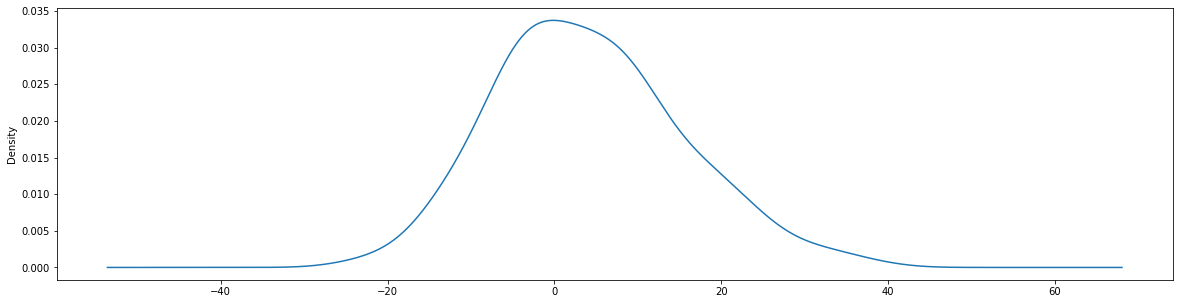

count    183.000000
mean       4.069950
std       11.218603
min      -23.180695
25%       -3.917816
50%        2.970894
75%       10.988295
max       37.648224
Name: maxO3, dtype: float64


In [ ]:
residuals_xg.plot(kind='kde', figsize=(20,5))
plt.show()
print(residuals_xg.describe())

D'après le graphiques des résidus, nous pouvons observer que le processus a une moyenne centrée autour de 4 et une variance constante. Cela signifie que la différence entre les valeurs réelles et les valeurs prévues par le modèle de série temporelle est en moyenne de 4. Cela peut indiquer que le modèle n'est pas entièrement approprié pour la série temporelle Ozone et que des ajustements supplémentaires doivent être effectués pour améliorer la qualité des prévisions.

On se rend compte que la série n'est pas stationnaire, il faut la différencier, ce que nous n'avions pas vu avec l'ACP. Même si la courbe décroissais rapidement vers 0, nous n'avions pas remarqué les légères oscillations.

## Stationnarisation

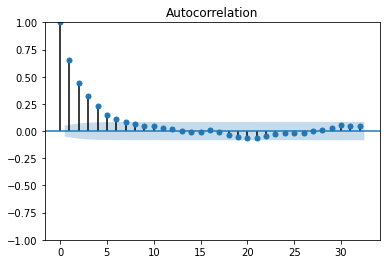

In [ ]:
#Notre ancien ACP
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(df2_acf['maxO3'], lags=nlag_max, ax=ax)
plt.show()

Nous allons différencier notre série une fois afin de voir si cette dernière devient stationnaire.

In [ ]:
df2_new = df2_copy.drop("day_of_week", axis = 1)

In [ ]:
df2_new.index = pd.to_datetime(df2_new.index)

In [ ]:
diff_df2 = df2_new.diff()

In [ ]:
diff_df2 = diff_df2.dropna()

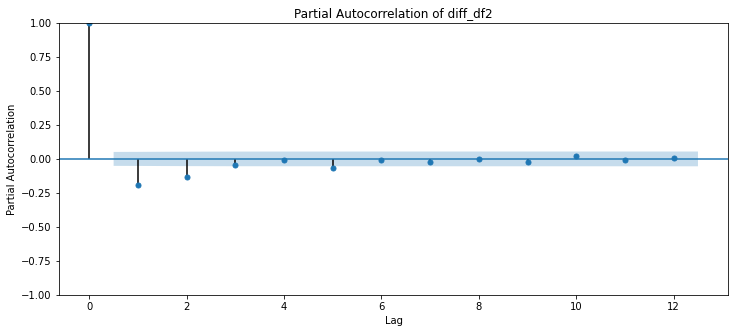

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# tracer l'ACP de diff_df2
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(diff_df2['maxO3'], ax=ax, lags=12)
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')
ax.set_title('Partial Autocorrelation of diff_df2')
plt.show()

On voit ici que L'ACP est une sinusoîdale amortie, la série est maintenant stationnaire.

## Modèle de régression linéaire avec ozone de la veille

Dans l'énoncé, il nous faut proposer un modèle de régression, nous choisissons un modèle de régression linéaire.

In [ ]:
split_date  = datetime.strptime('2002-01-01', '%Y-%m-%d')
df_train = diff_df2.loc[diff_df2.index < split_date]
df_test = diff_df2.loc[diff_df2.index >= split_date]

In [ ]:
X_train = df_train.drop(df_train.columns[0], axis=1)
y_train = df_train.iloc[:, 0]

X_test = df_test.drop(df_test.columns[0], axis=1)
y_test = df_test.iloc[:, 0]

In [ ]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()

LR.fit(X_train, y_train)

pred = LR.predict(X_test)

In [ ]:
print("RMSE: ", np.sqrt(mean_squared_error(pred, y_test)))

RMSE:  13.719385677099256


In [ ]:
# Sélection de la dernière prévision du modèle
pred_1 = pred[-1:]

# Sélection de la dernière valeur réelle de la série temporelle
y_test_1 = y_test[-1:]

print("RMSE: ", np.sqrt(mean_squared_error(pred_1, y_test_1)))

RMSE:  7.291776981401147


Le RMSE à horizon d'un jour avec un modèle de régression linéaire comprenant les données de la veille est de 7,29, et de 13, 71 sur la globalité des prédictions.

Ici, nous allons effectuer un test de Shapiro-Walk. Si la p-value est inférieure au seuil 0,05, on peut rejeter l'hypothèse d'une distribution normale pour les données.

In [ ]:
from scipy.stats import shapiro

residuals = y_test - pred

stat, p = shapiro(residuals)
print("Test statistique : ", stat)
print("p-value : ", p)

Test statistique :  0.985576331615448
p-value :  0.05722670257091522


Ici la p-value est de 0.057, nous allons rester souple et admettre que la distribution est normale, davantage au seuil des 10%.

## Modèle de régression linéaire sans ozone de la veille

In [ ]:
X_train = df_train.drop(["maxO3", "maxO3v"], axis=1)
y_train = df_train.iloc[:, 0]

X_test = df_test.drop(["maxO3", "maxO3v"], axis=1)
y_test = df_test.iloc[:, 0]

In [ ]:
LR = LinearRegression()

LR.fit(X_train, y_train)

pred = LR.predict(X_test)

In [ ]:
print("RMSE: ", np.sqrt(mean_squared_error(pred, y_test)))

RMSE:  13.878830325976296


In [ ]:
# Sélection de la dernière prévision du modèle
pred_1_2 = pred[-1:]

# Sélection de la dernière valeur réelle de la série temporelle
y_test_1_2 = y_test[-1:]

print("RMSE: ", np.sqrt(mean_squared_error(pred_1_2, y_test_1_2)))

RMSE:  7.45004914244095


Le RMSE à horizon d'un jour avec un modèle de régression linéaire comprenant les données de la veille est de 7,45, et de 13,87 sur la globalité des prédictions.

In [ ]:
from scipy.stats import shapiro

residuals = y_test - pred

stat, p = shapiro(residuals)
print("Test statistique : ", stat)
print("p-value : ", p)

Test statistique :  0.9897743463516235
p-value :  0.21458099782466888


Sans les données d'ozone de la veille, les résidus ne sont plus des bruits blancs selon le test de Shapiro-Walk.

## Conclusion

J'ai tout de suite tenté les modèles XGBoost car ce sont ceux les plus efficaces, cependant j'ai par la suite testé avec un modèle de régression linéaire simple quand j'ai vu que les résidus n'étaient pas des bruits blancs. Il fallait en effet les différencier pour avoir de bons résultats.

On voit que le RMSE du modèle XGBOOST avec les données de pic d'ozone de la veille est plus performant que celui sans les données du pic d'ozone de la veille pour tout le set de test (RMSE de 11.90 contre 14.3), mais pas à horizon d'un jour (RMSE de 2.01 contre 1.89). Il se peut que les données du pic d'ozone de la veille ne soient pas aussi pertinentes pour les prévisions à court terme, et au contraire influence trop les résultats sans prendre en compte les autres paramètres, pour ce modèle du moins.

Pour les modèles de régression linéaire, celui sans les données de la veille est non seulement moins performant du côté prédictif, mais les résidus ne sont pas des bruits blancs.
Le modèle avec les données de la veille a pour résidus des bruits blancs, et a de bonnes capacités prédictives (le RMSE à horizon d'un jour avec un modèle de régression linéaire comprenant les données de la veille est de 7,29, et de 13, 71 sur la globalité des prédictions). C'est donc celui que nous choisirions dans un cas réel.